In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import warnings
warnings.simplefilter("ignore")
# parentdir = os.path.abspath('../..')
# sys.path.insert(0, parentdir) 
from herculens_import_main import *
import jax
import numpyro
jax.config.update('jax_enable_x64', True)
numpyro.enable_x64()

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_async_collectives=true '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
)
if 'graphviz' not in os.environ['PATH']:
    os.environ['PATH'] = '/opt/apps/pkgs/graphviz/12.2.1/intel64/gnu_12.2.0/bin:' + os.environ['PATH']

[CudaDevice(id=0)]


In [2]:
pix_scale = 0.031  # arcsec / pixel (JWST)

DATA_DIR = "../Data/WFI2033"
raw_data_path = os.path.join(DATA_DIR, "jw01198-o004_t004_nircam_clear-f115w_i2d.fits")
data_path = os.path.join(DATA_DIR, "jw01198-o004_t004_nircam_clear-f115w_i2d_cut_x6985_y3594_150_rowmedcorr.fits")
mask_path = os.path.join(DATA_DIR, "mask.fits")
mask_out_path = os.path.join(DATA_DIR, "mask_out.fits")
# choose PSF source: "original", "starred", or "model"
PSF_SOURCE = "original"
psf_path_original = os.path.join(DATA_DIR, "F115W_PSF.fits")
psf_path_starred = os.path.join(DATA_DIR, "F115W_PSF_starred_x8101_y3465.fits")
psf_path_model = os.path.join("./psf_data", "PSF_model.fits")

with fits.open(raw_data_path, memmap=True) as hdul_raw:
    exposure_time = float(hdul_raw["SCI"].header["XPOSURE"])

with fits.open(data_path, memmap=True) as hdul:
    data = jnp.array(hdul["SCI"].data)
    rms_file = jnp.array(hdul["ERR"].data)

mask = jnp.array(fits.getdata(mask_path), dtype=bool)
mask_out_raw = fits.getdata(mask_out_path)
mask_out = jnp.array(1 - mask_out_raw, dtype=bool)
mask =  jnp.array(mask_out, dtype=bool)

valid = jnp.isfinite(data) & jnp.isfinite(rms_file) & (rms_file > 0)
mask = mask & valid
mask_out = mask_out & valid
if mask.shape != data.shape or mask_out.shape != data.shape:
    raise ValueError(f"Mask shape mismatch: data={data.shape}, mask={mask.shape}, mask_out={mask_out.shape}")
npix = int(mask_out.sum())

corner_pixel = 10
bkg_corner = np.array(data[:corner_pixel, :corner_pixel])
bkg_mean = float(np.nanmean(bkg_corner))
bkg_rms = float(np.nanstd(bkg_corner))

data = data - bkg_mean
rms = float(np.nanmedian(np.array(rms_file[mask_out])))

if PSF_SOURCE == "original":
    psf_hst = fits.getdata(psf_path_original)
    psf_used = psf_path_original
elif PSF_SOURCE == "starred":
    with fits.open(psf_path_starred, memmap=True) as hdul_psf:
        if "DET_PSF_NORM" in hdul_psf:
            psf_hst = np.array(hdul_psf["DET_PSF_NORM"].data, dtype=float)
        elif "DET_PSF_RAW" in hdul_psf:
            psf_raw = np.array(hdul_psf["DET_PSF_RAW"].data, dtype=float)
            psf_hst = np.clip(psf_raw, 0, None)
            psf_hst = psf_hst / np.sum(psf_hst)
        else:
            raise ValueError("Starred PSF FITS missing DET_PSF_NORM/DET_PSF_RAW extension")
    psf_used = psf_path_starred
elif PSF_SOURCE == "model":
    with fits.open(psf_path_model, memmap=True) as hdul_psf:
        if "DET_PSF_MODEL" in hdul_psf:
            psf_hst = np.array(hdul_psf["DET_PSF_MODEL"].data, dtype=float)
        elif "DET_PSF_NORM" in hdul_psf:
            psf_hst = np.array(hdul_psf["DET_PSF_NORM"].data, dtype=float)
        elif len(hdul_psf) > 1 and hdul_psf[1].data is not None:
            psf_hst = np.array(hdul_psf[1].data, dtype=float)
        elif hdul_psf[0].data is not None:
            psf_hst = np.array(hdul_psf[0].data, dtype=float)
        else:
            raise ValueError("PSF model FITS missing usable image extension")
    psf_hst = np.clip(psf_hst, 0, None)
    psf_hst = psf_hst / np.sum(psf_hst)
    psf_used = psf_path_model
else:
    raise ValueError(f"Unknown PSF_SOURCE={PSF_SOURCE}. Use 'original', 'starred', or 'model'.")

if psf_hst.shape[0] != psf_hst.shape[1] or psf_hst.shape[0] % 2 == 0:
    raise ValueError(f"PSF kernel must be square odd-sized, got {psf_hst.shape}")

print(f"Using PSF ({PSF_SOURCE}): {psf_used}")
psf = PSF(psf_type='PIXEL', kernel_point_source=psf_hst)

pixel_grid, xgrid, ygrid, x_axis, y_axis, extent, nx, ny = get_pixel_grid(data, pix_scale)
noise = Noise(nx, ny, exposure_time=exposure_time)
provided_rms = True

N_gauss_light = 15
N_gauss_source = 1

sigma_lims_lens = [0.000001, 0.5]
sigma_lims = [0.01, 0.1]

halfrange = [0.1, 0.1, 0.1]
source_grid_scale = 1

# four quasar image positions (arcsec, centered frame)
conj_points = jnp.array([
    [1.20212170716053, -0.12271885209256231],
    [0.9053233071260114, 0.5277189685977776],
    [-1.0461673774453952, 1.0081083299749878],
    [-0.1255456241215261, -0.8965524340129204],
])

ss_factor = 4

PSF_CORNER_SIZE = 5

def compute_psf_corner_median(psf_kernel, corner_size=PSF_CORNER_SIZE):
    ny, nx = psf_kernel.shape
    cs = min(corner_size, ny, nx)
    corners = np.concatenate([
        psf_kernel[:cs, :cs].reshape(-1),
        psf_kernel[:cs, -cs:].reshape(-1),
        psf_kernel[-cs:, :cs].reshape(-1),
        psf_kernel[-cs:, -cs:].reshape(-1),
    ])
    return float(np.nanmedian(corners))

psf_corner_median = compute_psf_corner_median(psf_hst, corner_size=PSF_CORNER_SIZE)
print(f"PSF corner median ({PSF_CORNER_SIZE}x{PSF_CORNER_SIZE}) = {psf_corner_median:.3e}")

def subtract_psf_corner_median(model_image, psf_median=psf_corner_median):
    return model_image - jnp.asarray(psf_median, dtype=model_image.dtype)


Using PSF (original): ../Data/WFI2033/F115W_PSF.fits


In [3]:
psf_jwst = fits.getdata(psf_path_original)
psf_starred = fits.getdata(psf_path_starred)

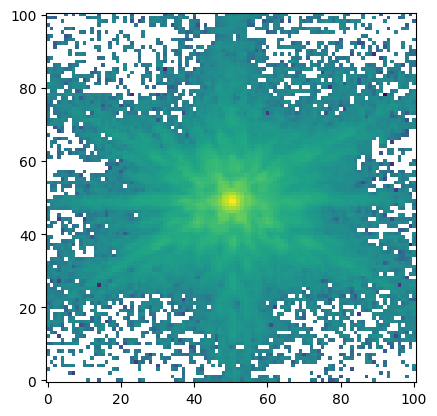

In [4]:
plt.imshow(psf_starred, norm = 'log')

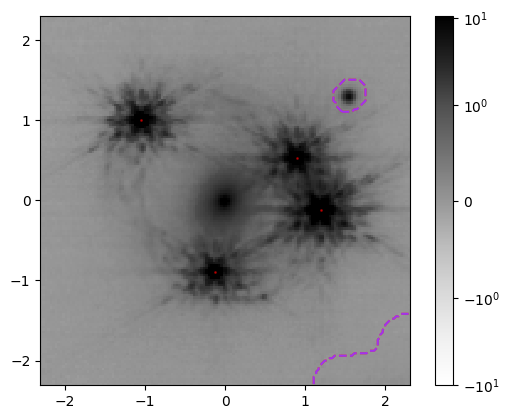

In [5]:
plt.imshow(data, origin='lower', cmap='Grays', extent=extent, norm=colors.SymLogNorm(linthresh = 1, vmax = 10.5, vmin = -10))
plt.colorbar();
plt.contour(mask, levels=[0.5], colors='#ff3300', alpha = 0.95, linewidth = 2, linestyles='dashed', origin='lower', extent=extent)
plt.contour(mask_out, levels=[0.5], colors='#9933ff', alpha = 0.95, linestyles='dashed', origin='lower', extent=extent)
plt.plot(conj_points[:, 0], conj_points[:, 1], 'o', alpha = 0.5, markersize = 1, color='red')

In [6]:
from herculens.PointSourceModel.point_source_model import PointSourceModel

mass_model = MassModel(['EPL', 'SHEAR'])

lens_light_model = LightModel(['MULTI_GAUSSIAN_ELLIPSE'],{})

source_light_model = LightModel(['MULTI_GAUSSIAN_ELLIPSE'],{})

point_source_model = PointSourceModel(
    ['IMAGE_POSITIONS'],
    mass_model=mass_model,
    image_plane=pixel_grid,
)

lens_image = LensImageExtension(
    pixel_grid,
    psf,
    noise_class=noise,
    lens_light_model_class=lens_light_model,
    lens_mass_model_class=mass_model,
    source_model_class=source_light_model,
    point_source_model_class=point_source_model,
    source_arc_mask=mask,
    conjugate_points=conj_points,
    kwargs_numerics={'supersampling_factor': ss_factor},
    source_grid_scale = source_grid_scale
)


In [7]:
npix = int(mask_out.sum())
def model(data, conj = True, provided_rms = False):
    mass_params = EPL_w_shear('Mass model', '1', gamma_low = 1.95, gamma_up = 2.05,theta_low = 0.9, theta_high = 1.1, center_high = 0.2, center_low = -0.2, e_low = -0.4, e_high = 0.1)
    lens_light = multi_gauss_light('Lens light', 'lens', N_gauss_light, sigma_lims = sigma_lims_lens,center_low=-0.2,center_high=0.2,e_high = 0.2, e_low = -0.2)

    n_ps = conj_points.shape[0]
    ra_ps = numpyro.sample(
        'ra_ps',
        dist.TruncatedNormal(
            loc=conj_points[:, 0],
            scale=0.05,
            low=conj_points[:, 0] - 0.2,
            high=conj_points[:, 0] + 0.2,
        ),
    )
    dec_ps = numpyro.sample(
        'dec_ps',
        dist.TruncatedNormal(
            loc=conj_points[:, 1],
            scale=0.05,
            low=conj_points[:, 1] - 0.2,
            high=conj_points[:, 1] + 0.2,
        ),
    )
    log10_amp_ps = numpyro.sample(
        'log10_amp_ps',
        dist.Uniform(-3.0, 4.5).expand([n_ps]),
    )
    kwargs_point_source = [{
        'ra': ra_ps,
        'dec': dec_ps,
        'amp': jnp.power(10.0, log10_amp_ps),
    }]

    conj_points_model = lens_image.trace_conjugate_points(mass_params)
    source_center = jnp.mean(conj_points_model, axis=0)
    source_light = multi_gauss_light_center(
        'Source light',
        'source',
        N_gauss_source,
        sigma_lims,
        center_det=source_center,
    )
    conj_distance = reduced_distance_matrix(conj_points_model)
    nc = conj_distance.shape[0]
    if conj:
        with numpyro.plate(f'Conjugate points 2 - [{nc}]', nc):
            numpyro.sample('conjugate_points', dist.Exponential(1000), obs=conj_distance)

    model_image_raw = lens_image.model(
        kwargs_lens=mass_params,
        kwargs_source=source_light,
        kwargs_lens_light=lens_light,
        kwargs_point_source=kwargs_point_source,
        source_add=True,
        point_source_add=True,
    )
    model_image = subtract_psf_corner_median(model_image_raw)
    numpyro.deterministic('psf_corner_median', jnp.asarray(psf_corner_median, dtype=model_image.dtype))

    if provided_rms:
        model_std = rms_file
    else:
        background_rms_model = numpyro.sample('RMS', dist.LogUniform(rms * 0.5, rms * 1.5))
        #lens_image.Noise._background_rms = background_rms_model
        model_var = lens_image.Noise.C_D_model(model_image_raw, background_rms = background_rms_model)
        model_std = jnp.sqrt(model_var)

    model_image_masked_out = model_image[mask_out]
    model_std_masked_out = model_std[mask_out]

    with numpyro.plate(f'Data masked - [{npix}]', npix):
        numpyro.sample('obs', dist.Normal(model_image_masked_out, model_std_masked_out), obs=data[mask_out])


def params2kwargs(params, fixed_params={}):
    params_full = params | fixed_params
    kwargs_lens = params2kwargs_EPL_w_shear(params_full, '1')
    kwargs_lens_light = params2kwargs_multi_gauss_light(params_full, 'lens')
    if 'center_source' not in params_full:
        conj_points_model = lens_image.trace_conjugate_points(kwargs_lens)
        source_center = jnp.mean(conj_points_model, axis=0)
        n_source = params_full['amp_source'].shape[0]
        center_source = jnp.vstack([
            jnp.full((n_source,), source_center[0]),
            jnp.full((n_source,), source_center[1]),
        ])
        params_full = params_full | {'center_source': center_source}
    kwargs_point_source = [{
        'ra': params_full['ra_ps'],
        'dec': params_full['dec_ps'],
        'amp': jnp.power(10.0, params_full['log10_amp_ps']),
    }]
    return {
        'kwargs_lens': kwargs_lens,
        'kwargs_source': params2kwargs_multi_gauss_light(params_full, 'source'),
        'kwargs_lens_light': kwargs_lens_light,
        'kwargs_point_source': kwargs_point_source,
    }

model_graph = numpyro.render_model(model, model_args=(data,), render_distributions=True)


Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

Running for 10,000 iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

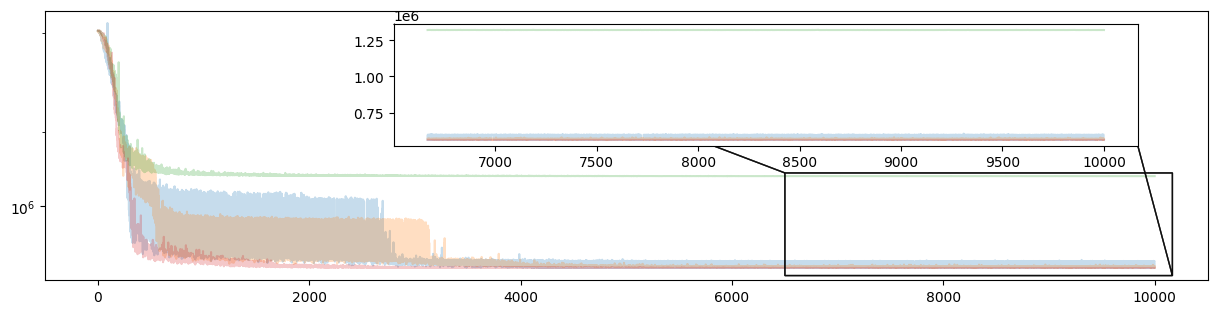

In [8]:
max_iterations = 10000
num_chains = 4

init_fun = infer.init_to_median(num_samples=25)
guide = autoguide.AutoLowRankMultivariateNormal(model, init_loc_fn=init_fun)
scheduler = split_scheduler(max_iterations, init_value=0.01, transition_steps=[200, 10])
optim = optax.adabelief(learning_rate=scheduler)
loss = infer.Trace_ELBO (num_particles=1)

rng_key = jax.random.PRNGKey(10)
rng_key, rng_key_ = jax.random.split(rng_key)
svi_keys = jax.random.split(rng_key_, num_chains)
svi = SVI_vec(model, guide, optim, loss)
multi_svi_results = svi.run(rng_key, num_chains, max_iterations, data, provided_rms = provided_rms, stable_update = True)
multi_svi_median = guide.median(multi_svi_results.params)

multi_svi_median_herc = median_params2kwargs(params2kwargs, multi_svi_median, jnp.arange(num_chains))


_, ax = plt.subplots(figsize=(15, 3.5))
axins = ax.inset_axes([0.3, 0.5, 0.64, 0.45])

for losses in multi_svi_results.losses:
    _ = plot_loss(losses, max_iterations, ax=ax, axins=axins, alpha=0.25)

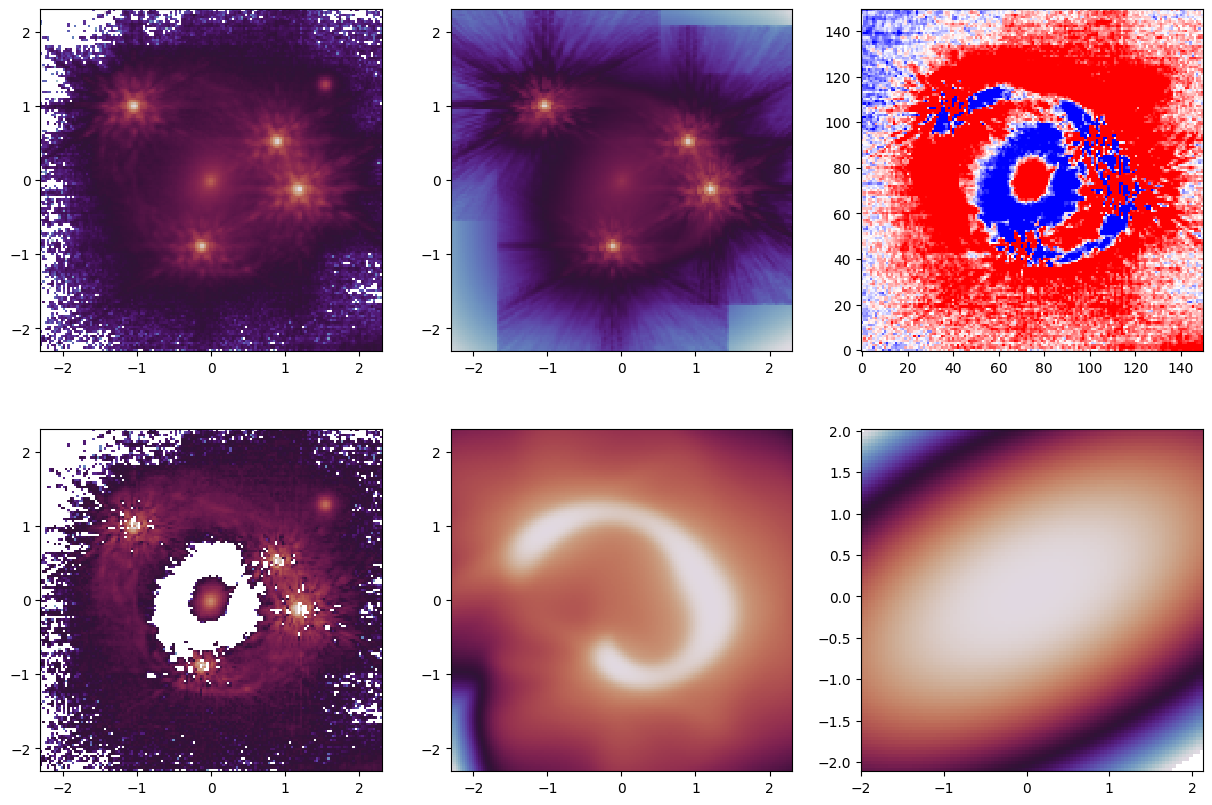

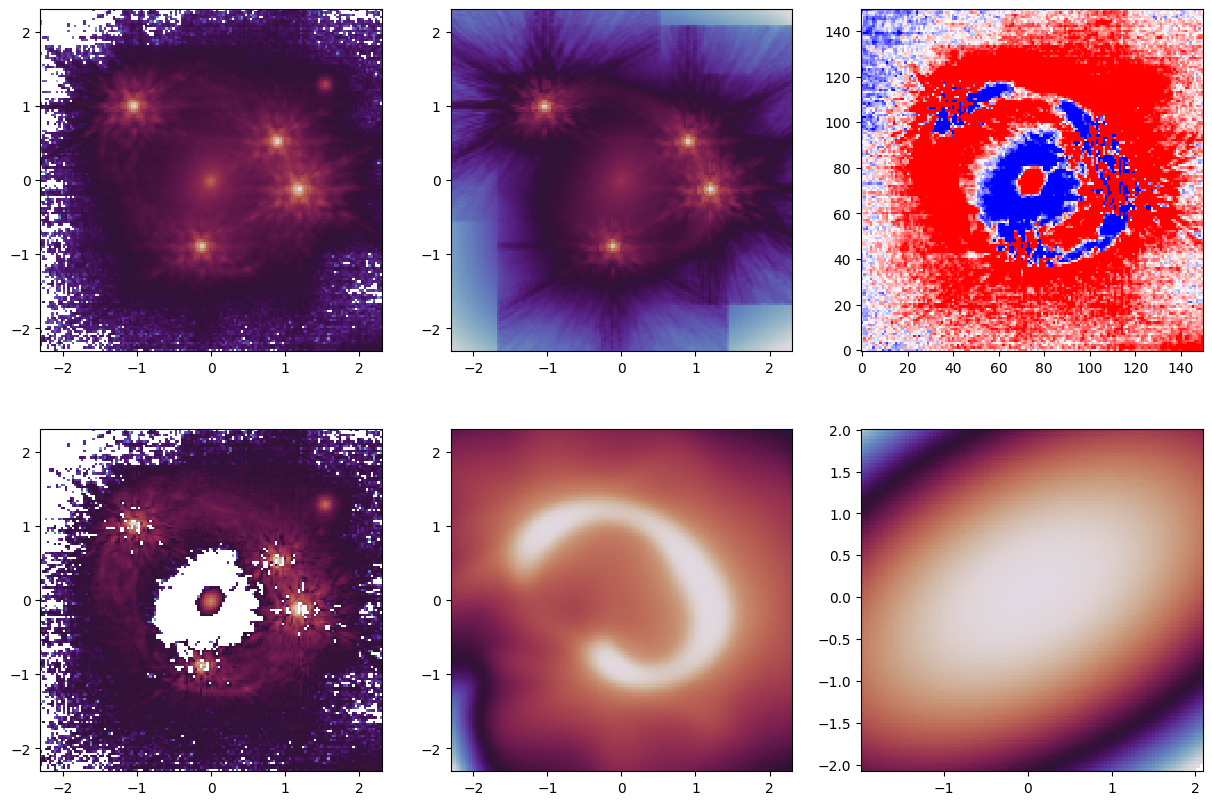

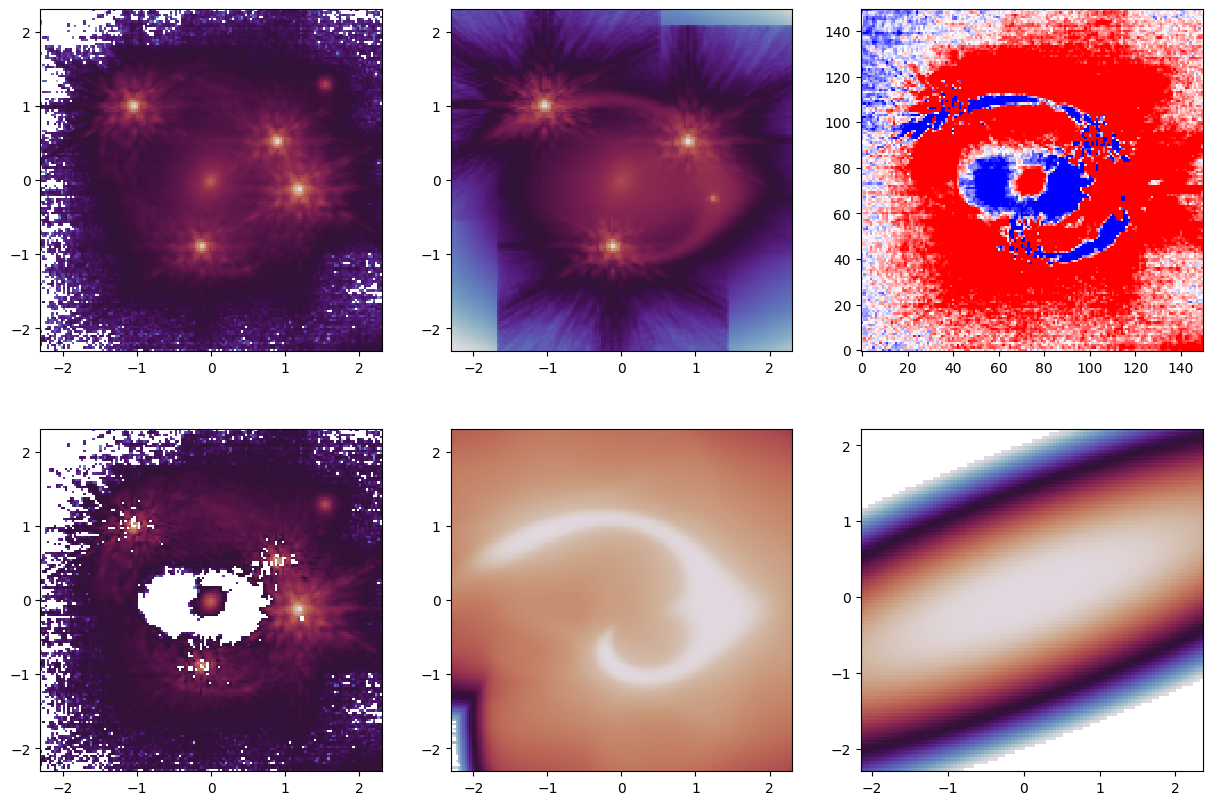

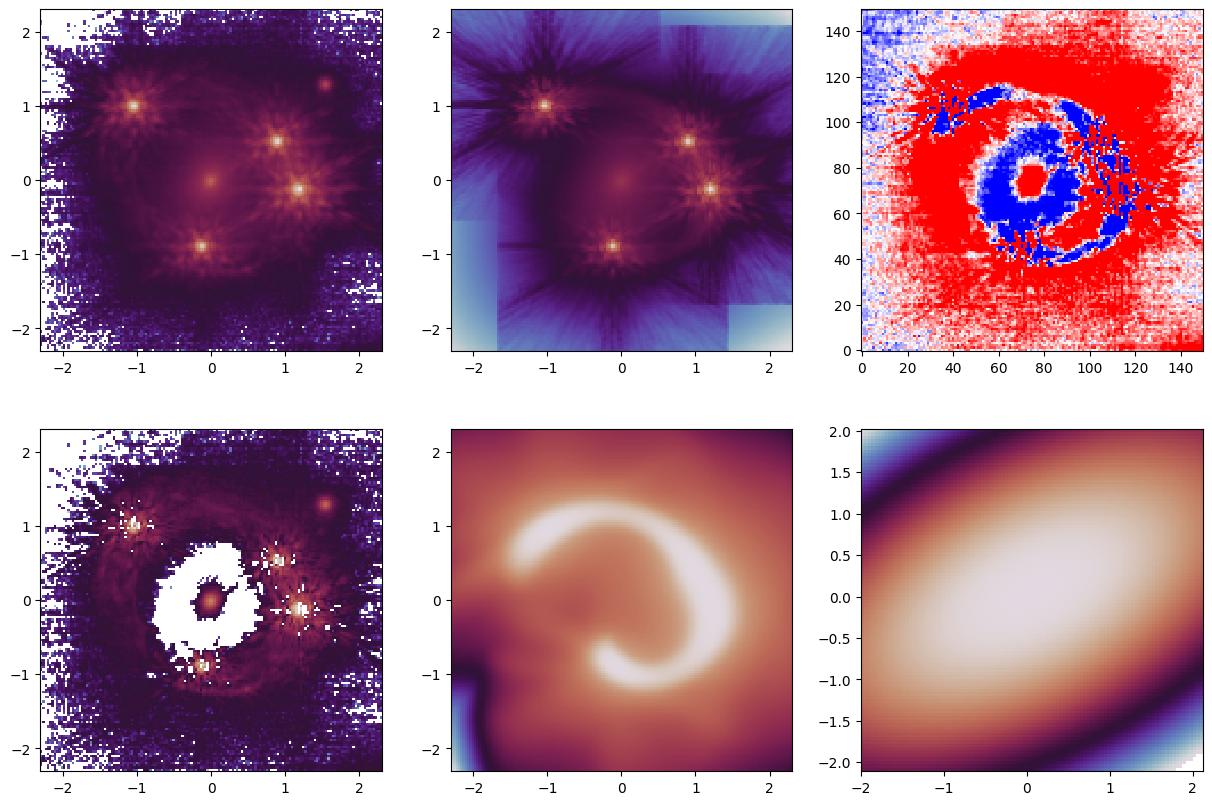

In [9]:
from lens_images_extension import pixelize_plane as pixelize_plane_single
for i in range(4):
    plt.figure(figsize = (15,10))
    plt.subplot(2,3,1)
    plt.imshow(data, norm = 'log', cmap = 'twilight', extent = extent, origin = 'lower')
    plt.subplot(2,3,2)
    image_model_raw = lens_image.model(**get_value_from_index(multi_svi_median_herc, i), source_add = True)
    image_model = subtract_psf_corner_median(image_model_raw)
    plt.imshow(image_model_raw, norm = 'log', cmap = 'twilight', extent = extent)
    plt.subplot(2,3,3)

    plt.imshow((data - image_model)/rms_file, cmap = 'bwr', vmax = 3, vmin = -3)
    plt.subplot(2,3,4)
    lens_light = lens_image.model(**get_value_from_index(multi_svi_median_herc, i), source_add = False)
    plt.imshow(data - lens_light, norm = 'log', cmap = 'twilight', extent = extent)

    plt.subplot(2,3,5)
    plt.imshow(image_model - lens_light, norm = 'log', cmap = 'twilight', extent = extent)
    plt.subplot(2,3,6)
    source, source_extent = pixelize_plane_single(
        lens_image,
        get_value_from_index(multi_svi_median_herc, i),
        100,
    )
    plt.imshow(source, extent = source_extent, norm = 'log', cmap = 'twilight')

In [10]:
best_pix_sizes = np.array([
    get_best_pixel_size(
        lens_image,
        get_value_from_index(multi_svi_median_herc, i),
        source_grid_scale
    ) for i in range(num_chains)
])
pixel_grid_shape = np.median(best_pix_sizes).astype(int)*1
# pixel_grid_shape = 250
print(pixel_grid_shape)

289


In [11]:
vars_mass = ['theta_E_1', 'gamma_1', 'e_1', 'center_1', 'gamma_sheer_1']
vars_lens_light = ['A_lens', 'sigma_lens','e_lens', 'center_lens']
vars_source_light = ['A_source', 'sigma_source', 'e_source']
vars_point_source = ['ra_ps', 'dec_ps', 'log10_amp_ps']
vars_other = []

svi_samples = guide.sample_posterior(rng_key_, multi_svi_results.params, sample_shape=(1000,))
svi_samples_chains = jax.tree.map(lambda x: jnp.swapaxes(x, 0, 1), svi_samples)
svi_samples_chains = jax.device_get(svi_samples_chains)
multi_svi_guide_sample = az.from_dict(svi_samples_chains)

k_grid = K_grid((pixel_grid_shape, pixel_grid_shape))

@jax.vmap
def get_image(idx):
    i, _ = pixelize_plane_single(lens_image, get_value_from_index(multi_svi_median_herc, idx), pixel_grid_shape, source_grid_scale=source_grid_scale)
    return i
orig_source = get_image(jnp.arange(num_chains))
ps_keys = jax.random.split(rng_key_, num_chains)
from herculens_import_main import source_power_spectrum
ps_fits = source_power_spectrum(orig_source, ps_keys, None, True)

keys_for_pixel_init = vars_lens_light + vars_mass + vars_point_source + vars_other
multi_svi_median_pixelated = {k: multi_svi_median[k] for k in keys_for_pixel_init if k in multi_svi_median} | ps_fits



In [12]:
k_grid = K_grid((pixel_grid_shape, pixel_grid_shape))

from herculens.PointSourceModel.point_source_model import PointSourceModel

mass_model_pixel = MassModel(['EPL', 'SHEAR'])
lens_light_model_pixel = LightModel(['MULTI_GAUSSIAN_ELLIPSE'],{})

source_light_model_pixel = LightModel(
    ['PIXELATED',],
    pixel_adaptive_grid=True,
    pixel_interpol='fast_bilinear',
    kwargs_pixelated={'num_pixels': pixel_grid_shape}
)

pixel_grid_pixel = deepcopy(pixel_grid)
psf_pixel = deepcopy(psf)

point_source_model_pixel = PointSourceModel(
    ['IMAGE_POSITIONS'],
    mass_model=mass_model_pixel,
    image_plane=pixel_grid_pixel,
)

lens_image_pixel = LensImageExtension(
    pixel_grid_pixel,
    psf_pixel,
    noise_class=noise,
    lens_light_model_class=lens_light_model_pixel,
    lens_mass_model_class=mass_model_pixel,
    source_model_class=source_light_model_pixel,
    point_source_model_class=point_source_model_pixel,
    source_arc_mask=mask,
    conjugate_points=conj_points,
    kwargs_numerics={'supersampling_factor': ss_factor},
    source_grid_scale=source_grid_scale,
)



In [13]:
npix = int(mask_out.sum())
N_HIGH_SOURCE_GRID = 1000
def model_pixel_full(data, k_values, conj=True, n_value = None):
    mass_params = EPL_w_shear('Mass model', '1', e_high = 0.1, e_low = -0.4)
    lens_light = multi_gauss_light('Lens light', 'lens', N_gauss_light, sigma_lims = sigma_lims_lens,center_low=-0.5,center_high=0.5,e_high = 0.2, e_low = -0.2)

    n_ps = conj_points.shape[0]
    ra_ps = numpyro.sample(
        'ra_ps',
        dist.TruncatedNormal(
            loc=conj_points[:, 0],
            scale=0.05,
            low=conj_points[:, 0] - 0.2,
            high=conj_points[:, 0] + 0.2,
        ),
    )
    dec_ps = numpyro.sample(
        'dec_ps',
        dist.TruncatedNormal(
            loc=conj_points[:, 1],
            scale=0.05,
            low=conj_points[:, 1] - 0.2,
            high=conj_points[:, 1] + 0.2,
        ),
    )
    log10_amp_ps = numpyro.sample(
        'log10_amp_ps',
        dist.Uniform(-3.0, 4.5).expand([n_ps]),
    )
    kwargs_point_source = [{
        'ra': ra_ps,
        'dec': dec_ps,
        'amp': jnp.power(10.0, log10_amp_ps),
    }]
    
    if conj:
        conj_points_model = lens_image_pixel.trace_conjugate_points(mass_params)
        conj_distance = reduced_distance_matrix(conj_points_model)
        nc = conj_distance.shape[0]
        with numpyro.plate(f'Conjugate points 2 - [{nc}]', nc):
            numpyro.sample('conjugate_points', dist.Exponential(100), obs=conj_distance)

    source_light = [
        matern_power_spectrum('Source grid', 'source_grid', k_values, n_high=N_HIGH_SOURCE_GRID, n_value = n_value, positive = True),
        #multi_gauss_light('Source light', 'source', 1, sigma_lims)[0]
    ]

    model_image_raw = lens_image_pixel.model(
        kwargs_lens=mass_params,
        kwargs_source=source_light,
        kwargs_lens_light=lens_light,
        kwargs_point_source=kwargs_point_source,
        point_source_add=True,
    )
    model_image = subtract_psf_corner_median(model_image_raw)
    numpyro.deterministic('psf_corner_median', jnp.asarray(psf_corner_median, dtype=model_image.dtype))
    
    if provided_rms:
        model_std = rms_file
    else:
        background_rms_model = numpyro.sample('RMS', dist.LogUniform(rms * 0.5, rms * 1.5))
        #lens_image.Noise._background_rms = background_rms_model
        model_var = lens_image.Noise.C_D_model(model_image_raw, background_rms = background_rms_model)
        model_std = jnp.sqrt(model_var)
        
    model_image_masked_out = model_image[mask_out]
    model_std_masked_out = model_std[mask_out]

    with numpyro.plate(f'Data masked - [{npix}]', npix):
        numpyro.sample('obs', dist.Normal(model_image_masked_out, model_std_masked_out), obs=data[mask_out])


def params2kwargs_pixel(params, fixed_params={}):
    params_full = params | fixed_params
    kwargs_lens = params2kwargs_EPL_w_shear(params_full, '1')
    kwargs_source = [params2kwargs_power_spectrum(params_full, 'source_grid'),]
    kwargs_lens_light = params2kwargs_multi_gauss_light(params_full, 'lens')
    kwargs_point_source = [{
        'ra': params_full['ra_ps'],
        'dec': params_full['dec_ps'],
        'amp': jnp.power(10.0, params_full['log10_amp_ps']),
    }]
    return {
        'kwargs_lens': kwargs_lens,
        'kwargs_source': kwargs_source,
        'kwargs_lens_light': kwargs_lens_light,
        'kwargs_point_source': kwargs_point_source,
    }

model_graph = numpyro.render_model(
    model_pixel_full,
    model_args=(data, k_grid.k),
    model_kwargs={'conj': False},
    render_distributions=True
)
#model_graph.unflatten(stagger=2)



[2026-02-17 23:08:13] running
[2026-02-17 23:10:13] running
SVI runs for 240.002 s which is 4.0 min


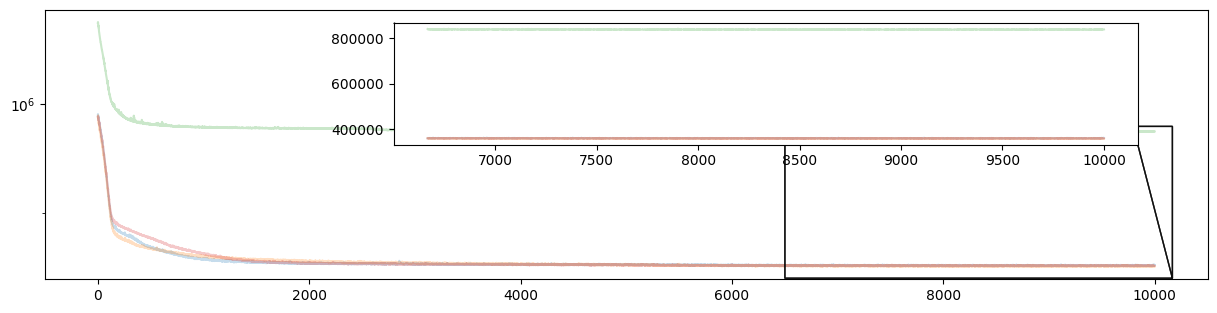

In [14]:
import time
import threading

def periodic_printer(interval, stop_event):
    while not stop_event.is_set():
        time.sleep(interval)
        print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] running")
        
stop_event = threading.Event()
printer_thread = threading.Thread(target=periodic_printer, args=(120, stop_event), daemon=True)
printer_thread.start()
start = time.time()
###############################################################################################################################
max_iterations = 10000
num_chains = 4

init_fun = init_to_value_or_defer(values=get_value_from_index(multi_svi_median_pixelated, 1))
guide_pixel = autoguide.AutoDiagonalNormal(model_pixel_full,init_loc_fn=init_fun,init_scale=0.01)

scheduler = split_scheduler(max_iterations,init_value=0.01,transition_steps=[200, 10])
optim = optax.adabelief(learning_rate=scheduler)
loss = infer.TraceMeanField_ELBO()

@jax.vmap
def map_svi_pixel(key, i):
    init_fun = init_to_value_or_defer(values=get_value_from_index(multi_svi_median_pixelated, i))
    guide_pixel.init_loc_fn = init_fun
    svi_pixel = infer.SVI(model_pixel_full,guide_pixel,optim,loss)
    return svi_pixel.run(key, max_iterations, data, k_grid.k, conj=True, n_value = None,  progress_bar=False, stable_update=True)

svi_keys = jax.random.split(rng_key_, num_chains)
multi_svi_pixel_results = map_svi_pixel(svi_keys, jnp.arange(num_chains))
multi_svi_pixel_median = guide_pixel.median(multi_svi_pixel_results.params)
multi_svi_pixel_median_herc = median_params2kwargs(params2kwargs_pixel,multi_svi_pixel_median,jnp.arange(num_chains))

stop_event.set()
printer_thread.join()
end = time.time()
print(f"SVI runs for {end - start:.3f} s which is {(end - start)/60:.1f} min")


_, ax = plt.subplots(figsize=(15, 3.5))
axins = ax.inset_axes([0.3, 0.5, 0.64, 0.45])

for losses in multi_svi_pixel_results.losses:
    _ = plot_loss(losses, max_iterations, ax=ax, axins=axins, alpha=0.25)

#383 source pixels: 6120s

In [ ]:
from lens_images_extension import pixelize_plane as pixelize_plane_single
for i in range(4):
    plt.figure(figsize = (15,10))
    plt.subplot(2,3,1)
    plt.imshow(data, norm = 'log', cmap = 'twilight', extent = extent, origin = 'lower')
    plt.subplot(2,3,2)
    image_model_raw = lens_image_pixel.model(**get_value_from_index(multi_svi_pixel_median_herc, i), source_add = True)
    image_model = subtract_psf_corner_median(image_model_raw)
    plt.imshow(image_model_raw, norm = 'log', cmap = 'twilight', extent = extent)
    plt.subplot(2,3,3)
    plt.imshow((data - image_model)/rms_file, cmap = 'bwr', vmax = 3, vmin = -3)
    plt.subplot(2,3,4)
    lens_light = lens_image_pixel.model(**get_value_from_index(multi_svi_pixel_median_herc, i), source_add = False)
    plt.imshow(data - lens_light, norm = 'log', cmap = 'twilight', extent = extent)

    plt.subplot(2,3,5)
    plt.imshow(image_model - lens_light, norm = 'log', cmap = 'twilight', extent = extent)
    plt.subplot(2,3,6)
    source, source_extent = pixelize_plane_single(
        lens_image_pixel,
        get_value_from_index(multi_svi_pixel_median_herc, i),
        pixel_grid_shape,
    )
    plt.imshow(source, extent = source_extent, norm = 'log', cmap = 'twilight')

In [ ]:
plt.imshow(source, extent = source_extent, norm = 'log', cmap = 'twilight')

### Corner plot

In [42]:
vars_power = ['n_source_grid', 'rho_source_grid', 'sigma_source_grid']
vars_power = ['rho_source_grid', 'sigma_source_grid']

svi_samples_pixel = guide_pixel.sample_posterior(rng_key_, multi_svi_pixel_results.params, sample_shape=(1000,))
svi_samples_pixel_chains = jax.tree.map(lambda x: jnp.swapaxes(x, 0, 1), svi_samples_pixel)
svi_samples_pixel_chains = jax.device_get(svi_samples_pixel_chains)
multi_svi_guide_sample_pixel = az.from_dict(svi_samples_pixel_chains)


In [44]:
import numpy as np

var_list = vars_mass + vars_power

# 1) 取每条 chain 的中心（median），得到 (chain, ) 的标量
#    multi_svi_guide_sample_pixel 通常是 xarray.Dataset，dims: (chain, draw)
cent = multi_svi_guide_sample_pixel[var_list].median(dim="draw")  # or .mean(dim="draw")

# 2) 拼成 (num_chains, ndim) 的 numpy 数组
X = np.column_stack([np.asarray(cent[v].values) for v in var_list])

# 3) scatter-only corner
from corner import corner  # 你现在就是在用这个

fig = corner(
    X,
    labels=var_list,
    plot_datapoints=True,
    plot_density=False,
    plot_contours=False,
    fill_contours=False,
    data_kwargs=dict(ms=10, marker="o", linestyle="None", alpha=0.9),  # 点更大：ms
    hist_kwargs=dict(density=True),
)


KeyError: ['theta_E_1', 'gamma_1', 'e_1', 'center_1', 'gamma_sheer_1', 'rho_source_grid', 'sigma_source_grid']

In [ ]:
best_i = int(multi_svi_pixel_results.losses[:, -1000:].mean(axis=1).argmin())

# lens_light = params2kwargs_gauss_light(get_value_from_index(multi_svi_pixel_median, best_i), 'lens', N_gauss_light, sigma_lims_lens)
# import pickle

# with open('lens_light_slice.pkl', 'wb') as f:
#     pickle.dump(lens_light, f)

# vars_fixed = vars_lens_light 
# svi_pixel_median = get_value_from_index(multi_svi_pixel_median, best_i)
# fixed_params_pixel = {k:svi_pixel_median[k] for k in vars_fixed}
# model_pixel_hmc_new = condition(model_pixel_full, fixed_params_pixel)

In [17]:
vars_other = ['RMS']

## HMC of the pixel grid model

As with the SVI we can extend the HMC to the full pixel grid model.  Keeping the lens light and parameterized source light fixed at the parameterized SVI solution, and initialize the model with the pixelated SVI solution.  Given the complex 

In [20]:
vars_pixel = ['pixels_wn_source_grid']
vars_power = ['n_source_grid', 'rho_source_grid', 'sigma_source_grid']
multi_svi_pixel_median_vars = {k: multi_svi_pixel_median[k] for k in vars_mass + vars_power + vars_pixel + vars_other+vars_lens_light}# + 
unconstrined_svi_pixel_median = jax.vmap(lambda p: infer.util.unconstrain_fn(model_pixel_full, (data, k_grid.k), {}, p))(multi_svi_pixel_median_vars)
#unconstrined_svi_pixel_median_trim = get_value_from_indexs(unconstrined_svi_pixel_median, jnp.array([2, 5, 8, 4]))

unconstrined_svi_pixel_median = {k: v.astype(jnp.float64) for k, v in unconstrined_svi_pixel_median.items()}
rng_key, rng_key_ = jax.random.split(rng_key)

In [46]:
# from numpyro.infer import NUTS, MCMC
# from custom_gibbs import MultiHMCGibbs

# init_fun_pixel = init_to_value_or_defer(values=get_value_from_index(multi_svi_pixel_median, 0))

# inner_kernels = [
#     NUTS(
#         model_pixel_full,
#         init_strategy=init_fun_pixel,
#         target_accept_prob=0.95,
#         max_tree_depth=10,
#         dense_mass=[('n_source_grid', 'rho_source_grid', 'sigma_source_grid'), ('A_lens', 'sigma_lens','e_lens', 'center_lens'), ('RMS',)],
#     ),
#     NUTS(
#         model_pixel_full,
#         init_strategy=init_fun_pixel,
#         target_accept_prob=0.95,
#         max_tree_depth=10,
#         dense_mass=[('center_1',), ('theta_E_1',), ('e_1', 'gamma_1', 'gamma_sheer_1')],
#     ),
# ]

# outer_kernel = MultiHMCGibbs(
#     inner_kernels,
#     gibbs_sites_list=[vars_pixel+vars_power+vars_lens_light + vars_other, vars_mass]
# )

# mcmc_pixel = MCMC(
#     outer_kernel,
#     num_warmup=1000,
#     num_samples=1000,
#     num_chains=num_chains,
#     progress_bar=True,
#     chain_method='vectorized'
# )

# batch_number = 8
# last_states = []
# batch_list = []
for i in range(batch_number):
    print(f'Batch {i+1}/{batch_number}')
    i+=6
    print('save', "/mnt/lustre/tianli/slice_hmc/slice_F606"+str(i)+".nc")
    
    if i == 0:
        mcmc_pixel.run(
            rng_key_,
            data,
            k_grid.k,
            conj=False,
            init_params=unconstrined_svi_pixel_median
        )
        last_states.append(jax.device_get(mcmc_pixel.last_state))
    else:
        mcmc_pixel.post_warmup_state = mcmc_pixel.last_state
        mcmc_pixel.run(
            mcmc_pixel.post_warmup_state.rng_key,
            data,
            k_grid.k,
            conj=False
        )
        last_states.append(jax.device_get(mcmc_pixel.last_state))

    mcmc_pixel._states = jax.device_get(mcmc_pixel._states)
    mcmc_pixel._states_flat = jax.device_get(mcmc_pixel._states_flat)
    mcmc_chain = az.from_numpyro(mcmc_pixel)
    mcmc_chain.to_netcdf("/mnt/lustre/tianli/slice_hmc/slice_F606"+str(i)+".nc")
    batch_list.append(mcmc_chain)



Batch 1/8
save /mnt/lustre/tianli/slice_hmc/slice_F6066.nc


sample: 100%|██████████| 1000/1000 [57:11<00:00,  3.43s/it]


Batch 2/8
save /mnt/lustre/tianli/slice_hmc/slice_F6067.nc


sample: 100%|██████████| 1000/1000 [57:21<00:00,  3.44s/it]


Batch 3/8
save /mnt/lustre/tianli/slice_hmc/slice_F6068.nc


sample: 100%|██████████| 1000/1000 [57:15<00:00,  3.44s/it]


Batch 4/8
save /mnt/lustre/tianli/slice_hmc/slice_F6069.nc


sample: 100%|██████████| 1000/1000 [57:28<00:00,  3.45s/it]


Batch 5/8
save /mnt/lustre/tianli/slice_hmc/slice_F60610.nc


sample: 100%|██████████| 1000/1000 [57:11<00:00,  3.43s/it]


Batch 6/8
save /mnt/lustre/tianli/slice_hmc/slice_F60611.nc


sample: 100%|██████████| 1000/1000 [57:21<00:00,  3.44s/it]


Batch 7/8
save /mnt/lustre/tianli/slice_hmc/slice_F60612.nc


sample: 100%|██████████| 1000/1000 [57:23<00:00,  3.44s/it]


Batch 8/8
save /mnt/lustre/tianli/slice_hmc/slice_F60613.nc


sample: 100%|██████████| 1000/1000 [57:14<00:00,  3.43s/it]


In [1]:
import arviz as az
import numpy as np
batch_list = []
for i in range(5):
    i+=8
    current_batch = az.from_netcdf("/mnt/lustre/tianli/slice_hmc/slice_F606"+str(i)+".nc")
    print('read', "/mnt/lustre/tianli/slice_hmc/slice_F606"+str(i)+".nc")
    
    batch_list.append(current_batch)
    
inf_data_pixel = az.concat(*batch_list, dim='draw')
vars_mass = ['theta_E_1', 'gamma_1', 'e_1', 'center_1', 'gamma_sheer_1']
vars_lens_light = ['A_lens', 'sigma_lens','e_lens', 'center_lens']
vars_source_light = ['A_source', 'sigma_source', 'e_source']
vars_other = []
vars_power = ['n_source_grid', 'rho_source_grid', 'sigma_source_grid']
print(f'divergences per chain per step:\n {inf_data_pixel.sample_stats.diverging.values.sum(axis=1).T}')
#az.summary(inf_data_pixel, var_names=vars_mass + vars_power + vars_other)
az.summary(inf_data_pixel.sel(chain=np.array([0,1,2,3])), var_names=vars_mass + vars_power + vars_other)

read /mnt/lustre/tianli/slice_hmc/slice_F6068.nc
read /mnt/lustre/tianli/slice_hmc/slice_F6069.nc
read /mnt/lustre/tianli/slice_hmc/slice_F60610.nc
read /mnt/lustre/tianli/slice_hmc/slice_F60611.nc
read /mnt/lustre/tianli/slice_hmc/slice_F60612.nc
divergences per chain per step:
 [[104  65 146  16]
 [  0   0   0   0]]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
theta_E_1[0]          1.904  0.002   1.901    1.907      0.000    0.000   
gamma_1[0]            2.579  0.012   2.558    2.602      0.003    0.001   
e_1[0, 0]            -0.070  0.005  -0.078   -0.061      0.001    0.000   
e_1[1, 0]            -0.117  0.005  -0.127   -0.107      0.001    0.000   
center_1[0]           0.036  0.002   0.033    0.039      0.000    0.000   
center_1[1]           0.055  0.002   0.052    0.058      0.000    0.000   
gamma_sheer_1[0, 0]  -0.130  0.001  -0.133   -0.128      0.000    0.000   
gamma_sheer_1[1, 0]   0.089  0.002   0.085    0.092      0.000    0.000   
n_source_grid[0]      0.009  0.008   0.000    0.024      0.000    0.000   
rho_source_grid[0]    4.360  3.783   0.342   10.904      0.190    0.274   
sigma_source_grid[0]  1.880  1.134   0.621    4.080      0.068    0.095   

                      ess_bulk  ess_tail  r_hat  
theta_E_1[0]              14.0     104.0   1.21  
gamma_1[0]                21.0     131.0   1.16  
e_1[0, 0]                 35.0     144.0   1.09  
e_1[1, 0]                 42.0      97.0   1.10  
center_1[0]               33.0      49.0   1.11  
center_1[1]               24.0      45.0   1.13  
gamma_sheer_1[0, 0]       22.0     140.0   1.14  
gamma_sheer_1[1, 0]       81.0     152.0   1.06  
n_source_grid[0]         520.0     342.0   1.01  
rho_source_grid[0]       309.0     580.0   1.01  
sigma_source_grid[0]     466.0     273.0   1.01

/tmp/ipykernel_172123/553366137.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


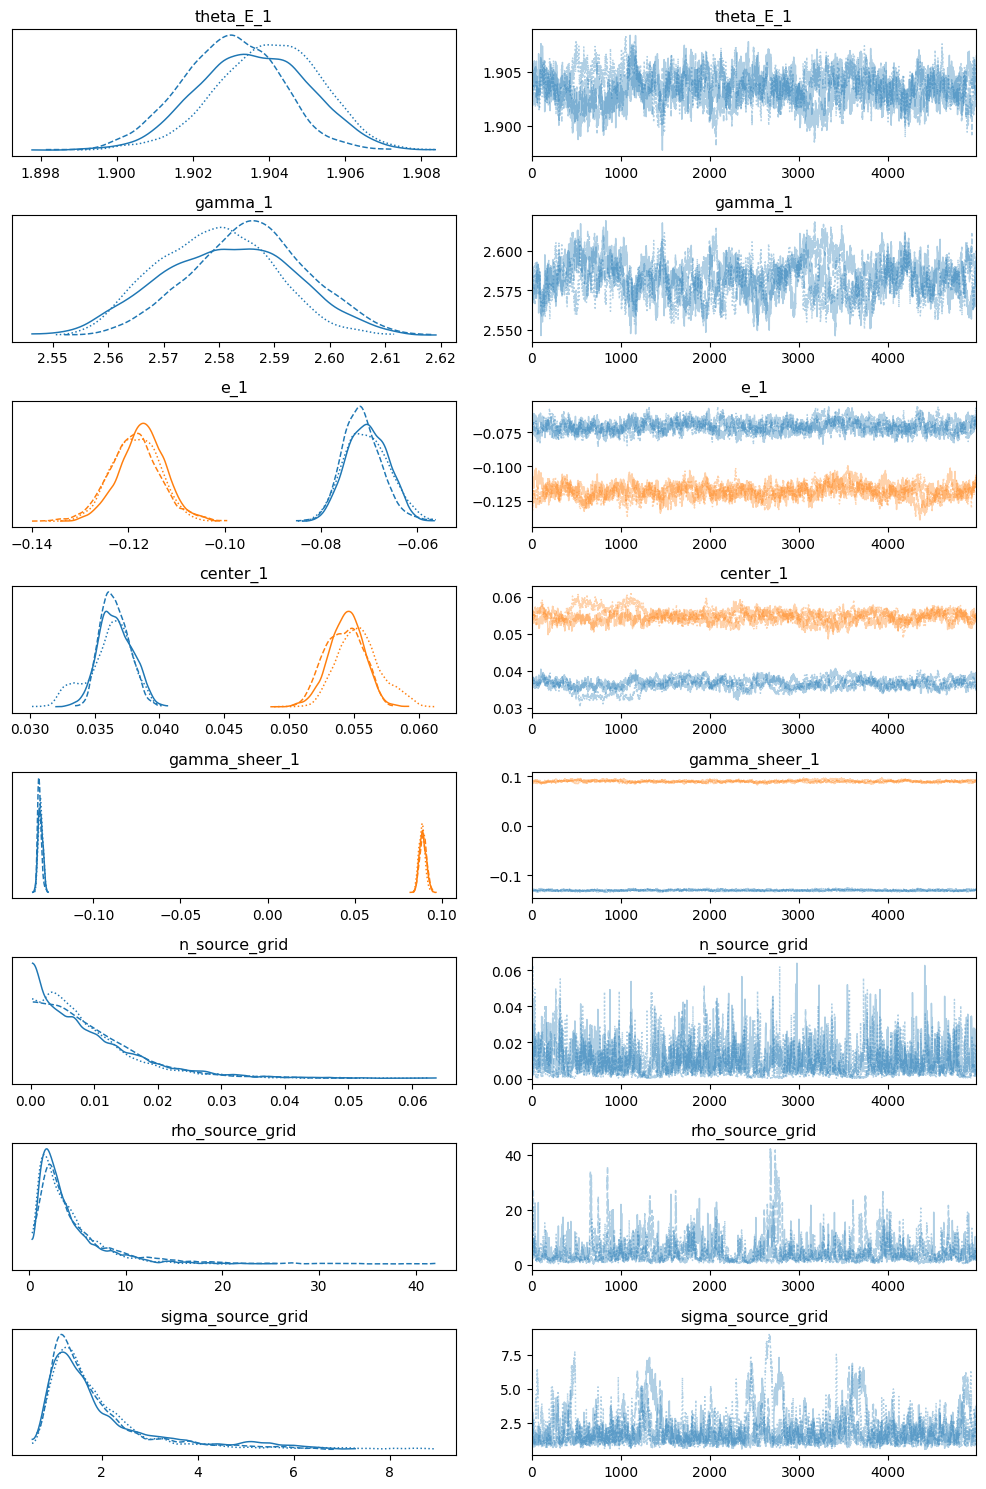

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['figure.constrained_layout.use'] = True
_ = az.plot_trace(inf_data_pixel.sel(chain=np.array([0,2,3])),var_names=vars_mass + vars_power + vars_other , figsize=(10, 15))
plt.tight_layout()

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import warnings
warnings.simplefilter("ignore")
# parentdir = os.path.abspath('../..')
# sys.path.insert(0, parentdir) 
from herculens_import_main import *
import jax
import numpyro
jax.config.update('jax_enable_x64', True)
numpyro.enable_x64()

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_async_collectives=true '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
)
if 'graphviz' not in os.environ['PATH']:
    os.environ['PATH'] = '/opt/apps/pkgs/graphviz/12.2.1/intel64/gnu_12.2.0/bin:' + os.environ['PATH']

[CudaDevice(id=0)]


In [2]:
import arviz as az
import numpy as np
    
inf_data_pixel = az.from_netcdf("/mnt/lustre/tianli/slice_hmc/inf_data_pixel_F606_concat.nc").sel(draw=slice(4000, None))
vars_mass = ['theta_E_1', 'gamma_1', 'e_1', 'center_1', 'gamma_sheer_1']
vars_lens_light = ['A_lens', 'sigma_lens','e_lens', 'center_lens']
vars_source_light = ['A_source', 'sigma_source', 'e_source']
vars_other = []
vars_power = ['n_source_grid', 'rho_source_grid', 'sigma_source_grid']

In [4]:
import numpy as np
import xarray as xr
import arviz as az

def _find_comp_dim(da: xr.DataArray, prefer_size=2):
    """Find the component dimension (e.g. e1/e2 or g1/g2) robustly."""
    other_dims = [d for d in da.dims if d not in ("chain", "draw")]
    for d in other_dims:
        if da.sizes[d] == prefer_size:
            return d
    raise ValueError(f"Cannot find a component dim of size {prefer_size} in dims={da.dims}, sizes={da.sizes}")

def e1e2_to_q_pa(e_da: xr.DataArray, degrees=True, wrap_to_180=True):
    """
    Assumes lenstronomy/herculens-style ellipticity:
        e = sqrt(e1^2 + e2^2) = (1-q)/(1+q)
        q = (1-e)/(1+e)
        PA = 0.5 * atan2(e2, e1)
    """
    comp = _find_comp_dim(e_da, prefer_size=2)
    e1 = e_da.isel({comp: 0})
    e2 = e_da.isel({comp: 1})

    e = np.sqrt(e1**2 + e2**2)
    q = (1 - e) / (1 + e)

    # guard: if e>=1 -> q<=0 (unphysical). set to nan
    q = xr.where(e < 1, q, np.nan)

    pa = 0.5 * np.arctan2(e2, e1)  # radians by default
    if degrees:
        pa = pa * 180.0 / np.pi
        if wrap_to_180:
            pa = (pa + 180.0) % 180.0  # [0, 180)
    return q, pa

def g1g2_to_mag_pa(g_da: xr.DataArray, degrees=True, wrap_to_180=True):
    """gamma = sqrt(g1^2+g2^2), PA = 0.5*atan2(g2,g1)."""
    comp = _find_comp_dim(g_da, prefer_size=2)
    g1 = g_da.isel({comp: 0})
    g2 = g_da.isel({comp: 1})

    gamma = np.sqrt(g1**2 + g2**2)
    pa = 0.5 * np.arctan2(g2, g1)
    if degrees:
        pa = pa * 180.0 / np.pi
        if wrap_to_180:
            pa = (pa + 180.0) % 180.0
    return gamma, pa

# --- add derived parameters into posterior ---
post = inf_data_pixel.posterior

q_1, pa_1 = e1e2_to_q_pa(post["e_1"], degrees=True, wrap_to_180=True)
shear_1, pa_shear_1 = g1g2_to_mag_pa(post["gamma_sheer_1"], degrees=True, wrap_to_180=True)

inf_data_pixel.posterior = post.assign(
    q_1=q_1,
    pa_1=pa_1,                 # degrees in [0,180)
    shear_1=shear_1,
    pa_shear_1=pa_shear_1      # degrees in [0,180)
)

# --- now use these in summary (i.e., "replace" e1/e2 and shear1/shear2) ---
vars_mass_new = ['theta_E_1', 'gamma_1', 'q_1', 'pa_1', 'center_1', 'shear_1', 'pa_shear_1']
az.summary(
    inf_data_pixel.sel(chain=[0,1,2,3]),
    var_names=vars_mass_new + vars_power + vars_other
)


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
theta_E_1[0]            1.904  0.001    1.901    1.907      0.000    0.000   
gamma_1[0]              2.579  0.012    2.559    2.601      0.002    0.000   
q_1[0]                  0.760  0.009    0.744    0.778      0.002    0.001   
pa_1[0]               119.632  0.727  118.267  121.016      0.028    0.010   
center_1[0]             0.037  0.002    0.034    0.039      0.000    0.000   
center_1[1]             0.055  0.002    0.052    0.058      0.000    0.000   
shear_1[0]              0.158  0.002    0.154    0.161      0.000    0.000   
pa_shear_1[0]          72.853  0.270   72.358   73.374      0.014    0.007   
n_source_grid[0]        0.009  0.008    0.000    0.024      0.000    0.000   
rho_source_grid[0]      4.396  3.902    0.331   11.054      0.148    0.196   
sigma_source_grid[0]    1.909  1.220    0.637    4.032      0.087    0.191   

                      ess_bulk  ess_tail  r_hat  
theta_E_1[0]              23.0     127.0   1.12  
gamma_1[0]                33.0     369.0   1.09  
q_1[0]                    33.0      77.0   1.09  
pa_1[0]                  690.0    2552.0   1.01  
center_1[0]              101.0      92.0   1.04  
center_1[1]              118.0     101.0   1.05  
shear_1[0]                40.0     548.0   1.08  
pa_shear_1[0]            376.0     544.0   1.01  
n_source_grid[0]         640.0     300.0   1.01  
rho_source_grid[0]       565.0    1363.0   1.01  
sigma_source_grid[0]     599.0     280.0   1.01

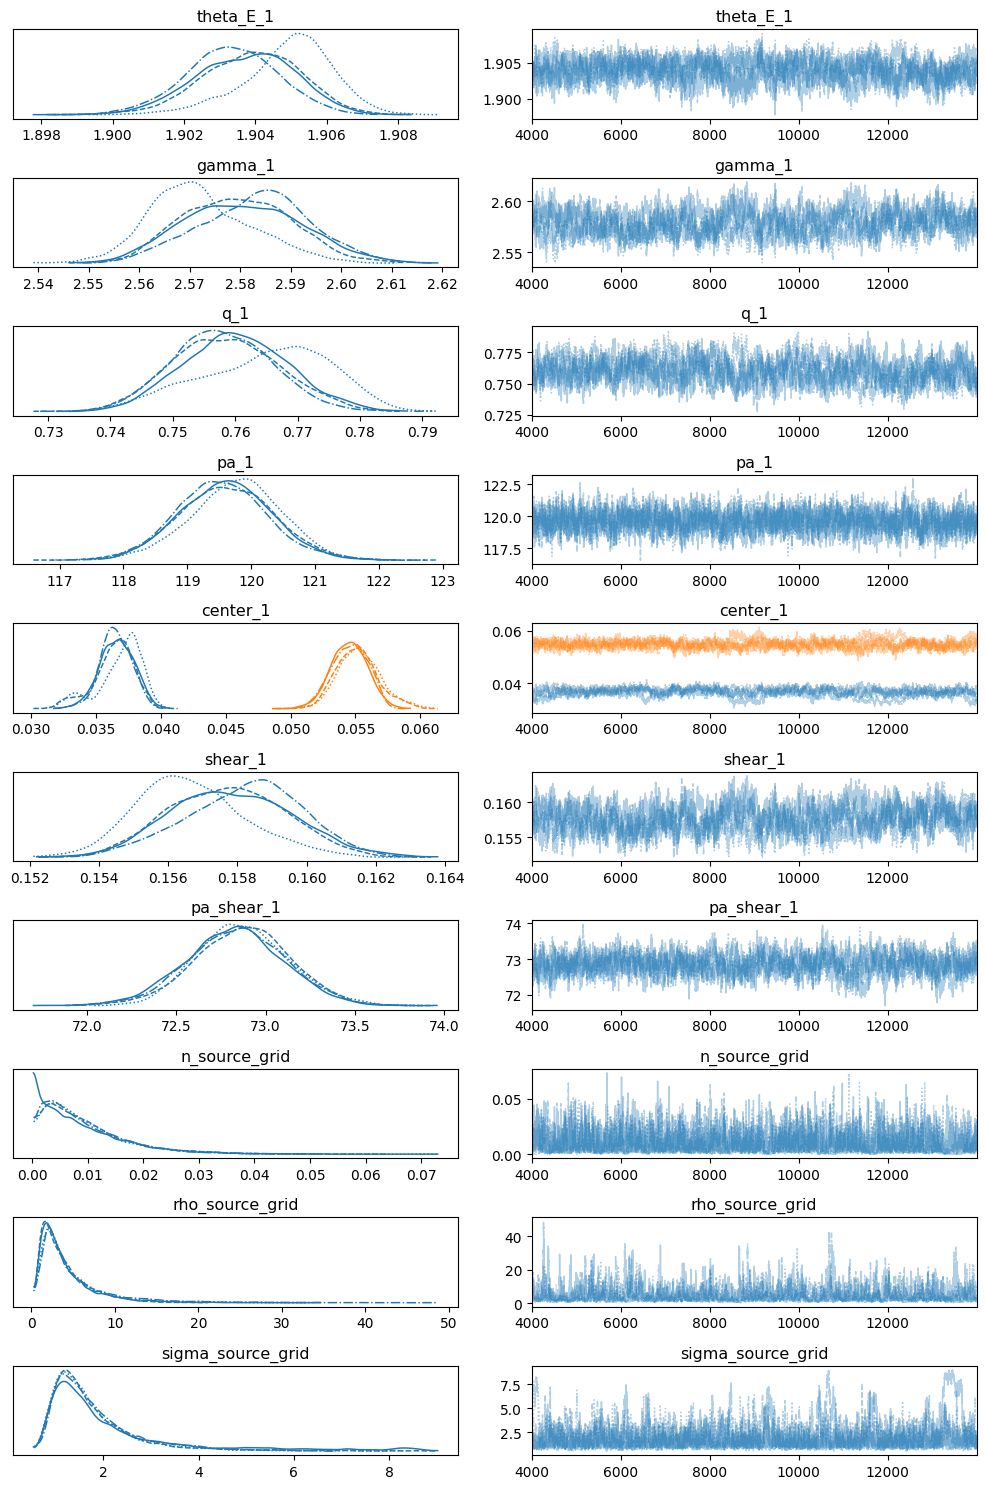

In [5]:
plt.rcParams['figure.constrained_layout.use'] = True
_ = az.plot_trace(inf_data_pixel, var_names=vars_mass_new + vars_power + vars_other , figsize=(10, 15))
plt.tight_layout()

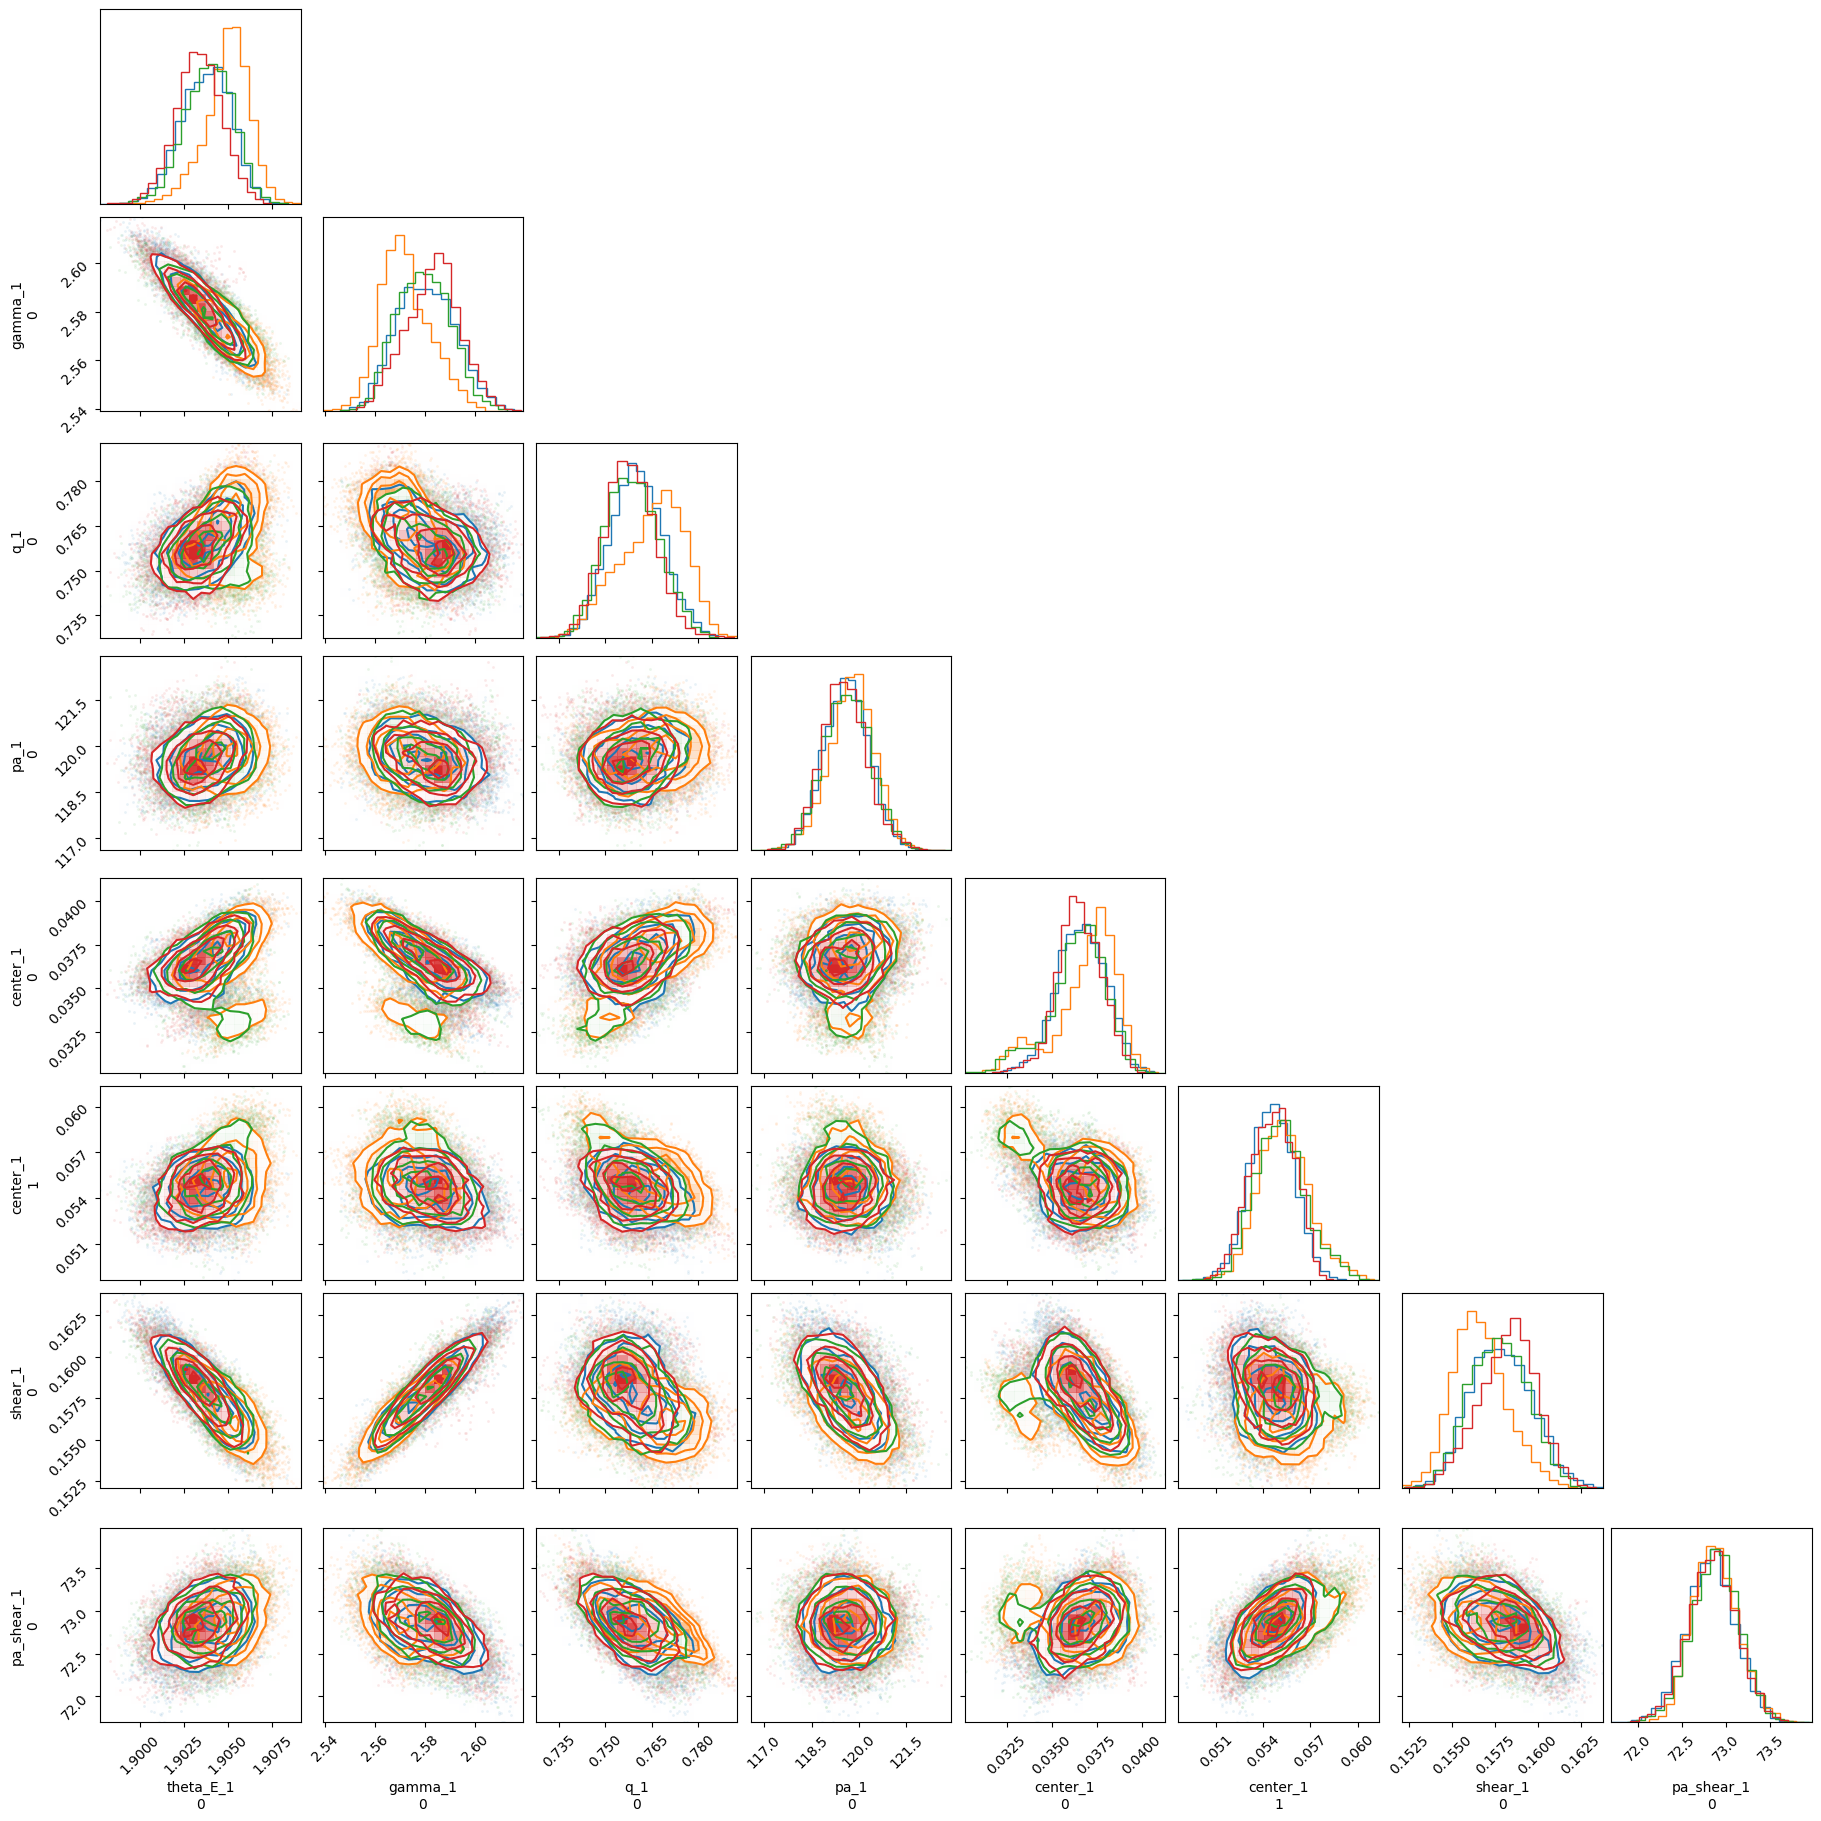

In [14]:
fig_corner = None
for i in range(4):
     fig_corner = corner(
         inf_data_pixel.isel(chain=i),
         var_names=vars_mass_new + vars_other,
         color = f'C{i}',
         fig=fig_corner,
         hist_kwargs={'density': True}
     )
plt.savefig('./result/corner_plot.pdf', dpi = 300)

In [6]:
pix_scale = 0.031  # arcsec / pixel (JWST)

DATA_DIR = "../Data/WFI2033"
raw_data_path = os.path.join(DATA_DIR, "jw01198-o004_t004_nircam_clear-f115w_i2d.fits")
data_path = os.path.join(DATA_DIR, "jw01198-o004_t004_nircam_clear-f115w_i2d_cut_x6985_y3594_150.fits")
mask_path = os.path.join(DATA_DIR, "mask.fits")
mask_out_path = os.path.join(DATA_DIR, "mask_out.fits")
# choose PSF source: "original", "starred", or "model"
PSF_SOURCE = "original"
psf_path_original = os.path.join(DATA_DIR, "F115W_PSF.fits")
psf_path_starred = os.path.join(DATA_DIR, "F115W_PSF_starred_x8101_y3465.fits")
psf_path_model = os.path.join("./psf_data", "PSF_model.fits")

with fits.open(raw_data_path, memmap=True) as hdul_raw:
    exposure_time = float(hdul_raw["SCI"].header["XPOSURE"])

with fits.open(data_path, memmap=True) as hdul:
    data = jnp.array(hdul["SCI"].data)
    rms_file = jnp.array(hdul["ERR"].data)

mask = jnp.array(fits.getdata(mask_path), dtype=bool)
mask_out_raw = fits.getdata(mask_out_path)
mask_out = jnp.array(1 - mask_out_raw, dtype=bool)

valid = jnp.isfinite(data) & jnp.isfinite(rms_file) & (rms_file > 0)
mask = mask & valid
mask_out = mask_out & valid
if mask.shape != data.shape or mask_out.shape != data.shape:
    raise ValueError(f"Mask shape mismatch: data={data.shape}, mask={mask.shape}, mask_out={mask_out.shape}")
npix = int(mask_out.sum())

corner_pixel = 10
bkg_corner = np.array(data[:corner_pixel, :corner_pixel])
bkg_mean = float(np.nanmean(bkg_corner))
bkg_rms = float(np.nanstd(bkg_corner))

data = data - bkg_mean
rms = float(np.nanmedian(np.array(rms_file[mask_out])))

if PSF_SOURCE == "original":
    psf_hst = fits.getdata(psf_path_original)
    psf_used = psf_path_original
elif PSF_SOURCE == "starred":
    with fits.open(psf_path_starred, memmap=True) as hdul_psf:
        if "DET_PSF_NORM" in hdul_psf:
            psf_hst = np.array(hdul_psf["DET_PSF_NORM"].data, dtype=float)
        elif "DET_PSF_RAW" in hdul_psf:
            psf_raw = np.array(hdul_psf["DET_PSF_RAW"].data, dtype=float)
            psf_hst = np.clip(psf_raw, 0, None)
            psf_hst = psf_hst / np.sum(psf_hst)
        else:
            raise ValueError("Starred PSF FITS missing DET_PSF_NORM/DET_PSF_RAW extension")
    psf_used = psf_path_starred
elif PSF_SOURCE == "model":
    with fits.open(psf_path_model, memmap=True) as hdul_psf:
        if "DET_PSF_MODEL" in hdul_psf:
            psf_hst = np.array(hdul_psf["DET_PSF_MODEL"].data, dtype=float)
        elif "DET_PSF_NORM" in hdul_psf:
            psf_hst = np.array(hdul_psf["DET_PSF_NORM"].data, dtype=float)
        elif len(hdul_psf) > 1 and hdul_psf[1].data is not None:
            psf_hst = np.array(hdul_psf[1].data, dtype=float)
        elif hdul_psf[0].data is not None:
            psf_hst = np.array(hdul_psf[0].data, dtype=float)
        else:
            raise ValueError("PSF model FITS missing usable image extension")
    psf_hst = np.clip(psf_hst, 0, None)
    psf_hst = psf_hst / np.sum(psf_hst)
    psf_used = psf_path_model
else:
    raise ValueError(f"Unknown PSF_SOURCE={PSF_SOURCE}. Use 'original', 'starred', or 'model'.")

if psf_hst.shape[0] != psf_hst.shape[1] or psf_hst.shape[0] % 2 == 0:
    raise ValueError(f"PSF kernel must be square odd-sized, got {psf_hst.shape}")

print(f"Using PSF ({PSF_SOURCE}): {psf_used}")
psf = PSF(psf_type='PIXEL', kernel_point_source=psf_hst)

pixel_grid, xgrid, ygrid, x_axis, y_axis, extent, nx, ny = get_pixel_grid(data, pix_scale)
noise = Noise(nx, ny, exposure_time=exposure_time)
provided_rms = True

N_gauss_light = 8
N_gauss_source = 4

sigma_lims_lens = [0.01, 1]
sigma_lims = [0.01, 1]

halfrange = [0.1, 0.1, 0.1]
source_grid_scale = 0.8
conj_points = jnp.array([
    [0.8, -1.1],
    [0.1, 2.75],
])
ss_factor = 2

PSF_CORNER_SIZE = 5

def compute_psf_corner_median(psf_kernel, corner_size=PSF_CORNER_SIZE):
    ny, nx = psf_kernel.shape
    cs = min(corner_size, ny, nx)
    corners = np.concatenate([
        psf_kernel[:cs, :cs].reshape(-1),
        psf_kernel[:cs, -cs:].reshape(-1),
        psf_kernel[-cs:, :cs].reshape(-1),
        psf_kernel[-cs:, -cs:].reshape(-1),
    ])
    return float(np.nanmedian(corners))

psf_corner_median = compute_psf_corner_median(psf_hst, corner_size=PSF_CORNER_SIZE)
print(f"PSF corner median ({PSF_CORNER_SIZE}x{PSF_CORNER_SIZE}) = {psf_corner_median:.3e}")

def subtract_psf_corner_median(model_image, psf_median=psf_corner_median):
    return model_image - jnp.asarray(psf_median, dtype=model_image.dtype)


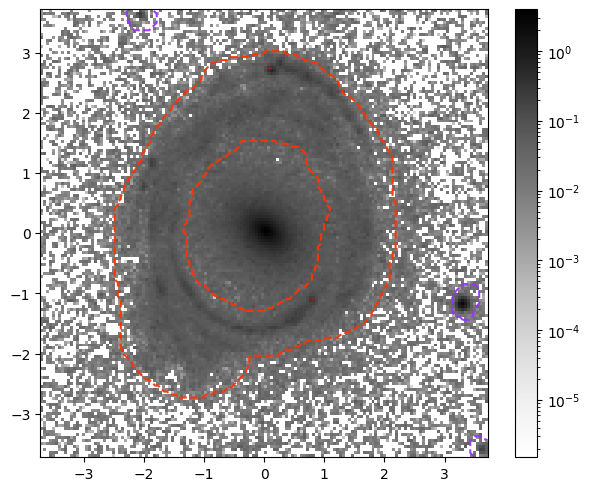

In [9]:
plt.imshow(data, origin='lower', cmap='Grays', extent=extent, norm="log")
plt.colorbar();
plt.contour(mask, levels=[0.5], colors='#ff3300', alpha = 0.95, linewidth = 2, linestyles='dashed', origin='lower', extent=extent)
plt.contour(mask_out, levels=[0.5], colors='#9933ff', alpha = 0.95, linestyles='dashed', origin='lower', extent=extent)
plt.plot(conj_points[:, 0], conj_points[:, 1], 'o', alpha = 0.5, markersize = 1, color='red')

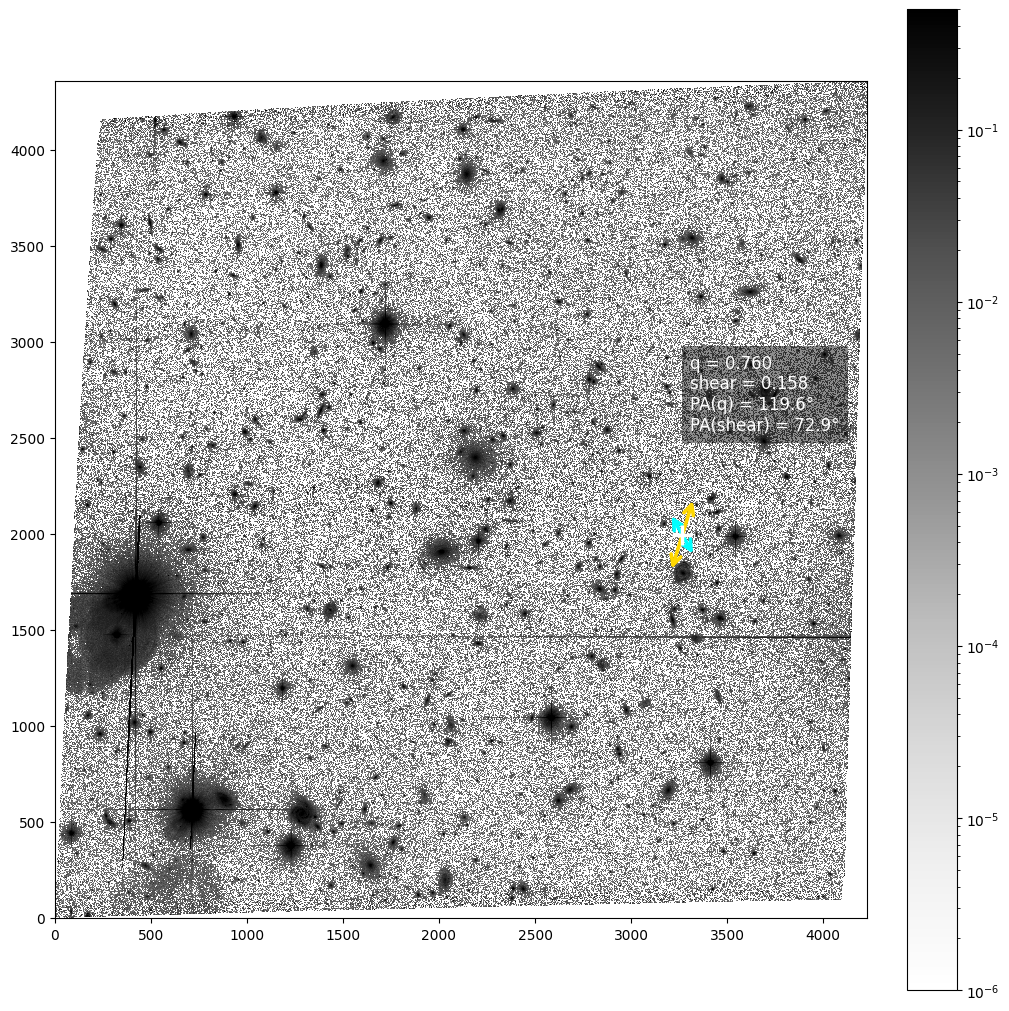

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import colors
from matplotlib.patches import FancyArrowPatch

# ---------------- user inputs ----------------
fits_path = "je280w010_drc.fits"   # 改成你的实际路径
x0, y0 = 3267, 1796+200               # 你指定的位置
vmax = 0.5                        # 你要的 max
vmin_pos = 1e-6                   # log norm 必须 >0；用一个很小的正数近似“0”
# --------------------------------------------

def read_sci_data(path):
    """Prefer SCI extension if present; fallback to ext=0."""
    with fits.open(path, memmap=True) as hdul:
        for ext in [("SCI", 1), 1, 0]:
            try:
                data = hdul[ext].data
                if data is not None:
                    return np.array(data, dtype=float)
            except Exception:
                pass
    raise RuntimeError(f"Cannot read science data from {path}")

def scalar_from_posterior(post, name):
    """
    Take median over chain/draw.
    If extra dims exist (e.g. size-1 dims), squeeze them; if size>1 dims exist, take index 0.
    """
    da = post[name]
    for d in list(da.dims):
        if d not in ("chain", "draw") and da.sizes[d] > 1:
            da = da.isel({d: 0})
    da = da.squeeze(drop=True)
    vals = da.stack(sample=("chain", "draw")).values
    return float(np.nanmedian(vals))

# --- pull parameters directly from your InferenceData ---
post = inf_data_pixel.posterior
q = scalar_from_posterior(post, "q_1")
pa_e_deg = scalar_from_posterior(post, "pa_1")
shear = scalar_from_posterior(post, "shear_1")
pa_s_deg = scalar_from_posterior(post, "pa_shear_1")

# --- read full image ---
img = read_sci_data(fits_path)
ny, nx = img.shape
extent = (0, nx, 0, ny)

# log norm: mask <=0 so LogNorm is well-defined
img_m = np.ma.masked_less_equal(img, 0.0)
norm = colors.LogNorm(vmin=vmin_pos, vmax=vmax, clip=True)

# --- plot ---
plt.figure(figsize=(10, 10))
im = plt.imshow(img_m, origin="lower", cmap="Greys", extent=extent, norm=norm, interpolation="none")
plt.colorbar(im)

ax = plt.gca()

# marker at (x0,y0)
ax.plot([x0], [y0], marker="+", markersize=14, mew=2.5, color="white", zorder=12)

# arrow lengths (in pixels) — adjust if you want bigger/smaller
L0 = 0.03 * nx   # ellipticity arrow base length

# ellipticity PA (double-headed axis)
theta_e = np.deg2rad(pa_e_deg)
dx_e, dy_e = L0 * np.cos(theta_e), L0 * np.sin(theta_e)
ax.add_patch(FancyArrowPatch(
    (x0 - dx_e, y0 - dy_e), (x0 + dx_e, y0 + dy_e),
    arrowstyle="<->", mutation_scale=18,
    linewidth=2.6, color="cyan", zorder=11
))

# shear PA (double-headed axis), scaled by |shear|
Ls = L0 * np.clip(shear / 0.10, 0.6, 2.0)
theta_s = np.deg2rad(pa_s_deg)
dx_s, dy_s = Ls * np.cos(theta_s), Ls * np.sin(theta_s)
ax.add_patch(FancyArrowPatch(
    (x0 - dx_s, y0 - dy_s), (x0 + dx_s, y0 + dy_s),
    arrowstyle="<->", mutation_scale=18,
    linewidth=2.6, color="gold", zorder=11
))

# label q and shear at (x0,y0)
ax.text(
    x0 + 0.01 * nx, y0 + 0.01 * ny+500,
    f"q = {q:.3f}\nshear = {shear:.3f}\nPA(q) = {pa_e_deg:.1f}°\nPA(shear) = {pa_s_deg:.1f}°",
    color="white", fontsize=12,
    bbox=dict(facecolor="black", alpha=0.45, edgecolor="none", pad=6),
    zorder=13
)

plt.xlim(0, nx)
plt.ylim(0, ny)
plt.show()


In [22]:
pixel_grid_shape = 61
k_grid = K_grid((pixel_grid_shape, pixel_grid_shape))

mass_model_pixel = MassModel(['EPL', 'SHEAR'])

lens_light_model = LightModel(['MULTI_GAUSSIAN_ELLIPSE'],{})

source_light_model_pixel = LightModel(
    ['PIXELATED'],
    pixel_adaptive_grid=True,
    pixel_interpol='fast_bilinear',
    kwargs_pixelated={'num_pixels': pixel_grid_shape}
)

lens_image_pixel = LensImageExtension(
    deepcopy(pixel_grid),
    deepcopy(psf),
    noise_class=noise,
    lens_light_model_class=lens_light_model,
    lens_mass_model_class=mass_model_pixel,
    source_model_class=source_light_model_pixel,
    source_arc_mask=mask,
    #source_arc_mask=jnp.ones_like(data, dtype=bool),
    conjugate_points=conj_points,
    kwargs_numerics={'supersampling_factor': ss_factor},
    source_grid_scale=source_grid_scale,
)

In [23]:
def params2kwargs_pixel(params, fixed_params={}):
    params_full = params | fixed_params
    kwargs_lens = params2kwargs_EPL_w_shear(params_full, '1')
    kwargs_source = [params2kwargs_power_spectrum(params, 'source_grid'),]
    kwargs_lens_light = params2kwargs_multi_gauss_light(params_full, 'lens')
    return {
        'kwargs_lens': kwargs_lens,
        'kwargs_source': kwargs_source,
        'kwargs_lens_light': kwargs_lens_light
    }



hmc_median_pixel = inf_data_pixel.posterior.median(dim=('chain', 'draw'))
hmc_std_pixel = inf_data_pixel.posterior.std(dim=('chain', 'draw'))

hmc_median_pixel = {k: v.data for k, v in hmc_median_pixel.data_vars.items()}
hmc_median_pixel_herc = params2kwargs_pixel(hmc_median_pixel)#, fixed_params=fixed_params_pixel)

hmc_median_pixel_by_chain = inf_data_pixel.posterior.median(dim=('draw'))

hmc_median_pixel_by_chain = {k: v.data for k, v in hmc_median_pixel_by_chain.data_vars.items()}

hmc_median_pixel_herc_by_chian = median_params2kwargs(
    partial(params2kwargs_pixel),
    hmc_median_pixel_by_chain,
    jnp.arange(4)
)

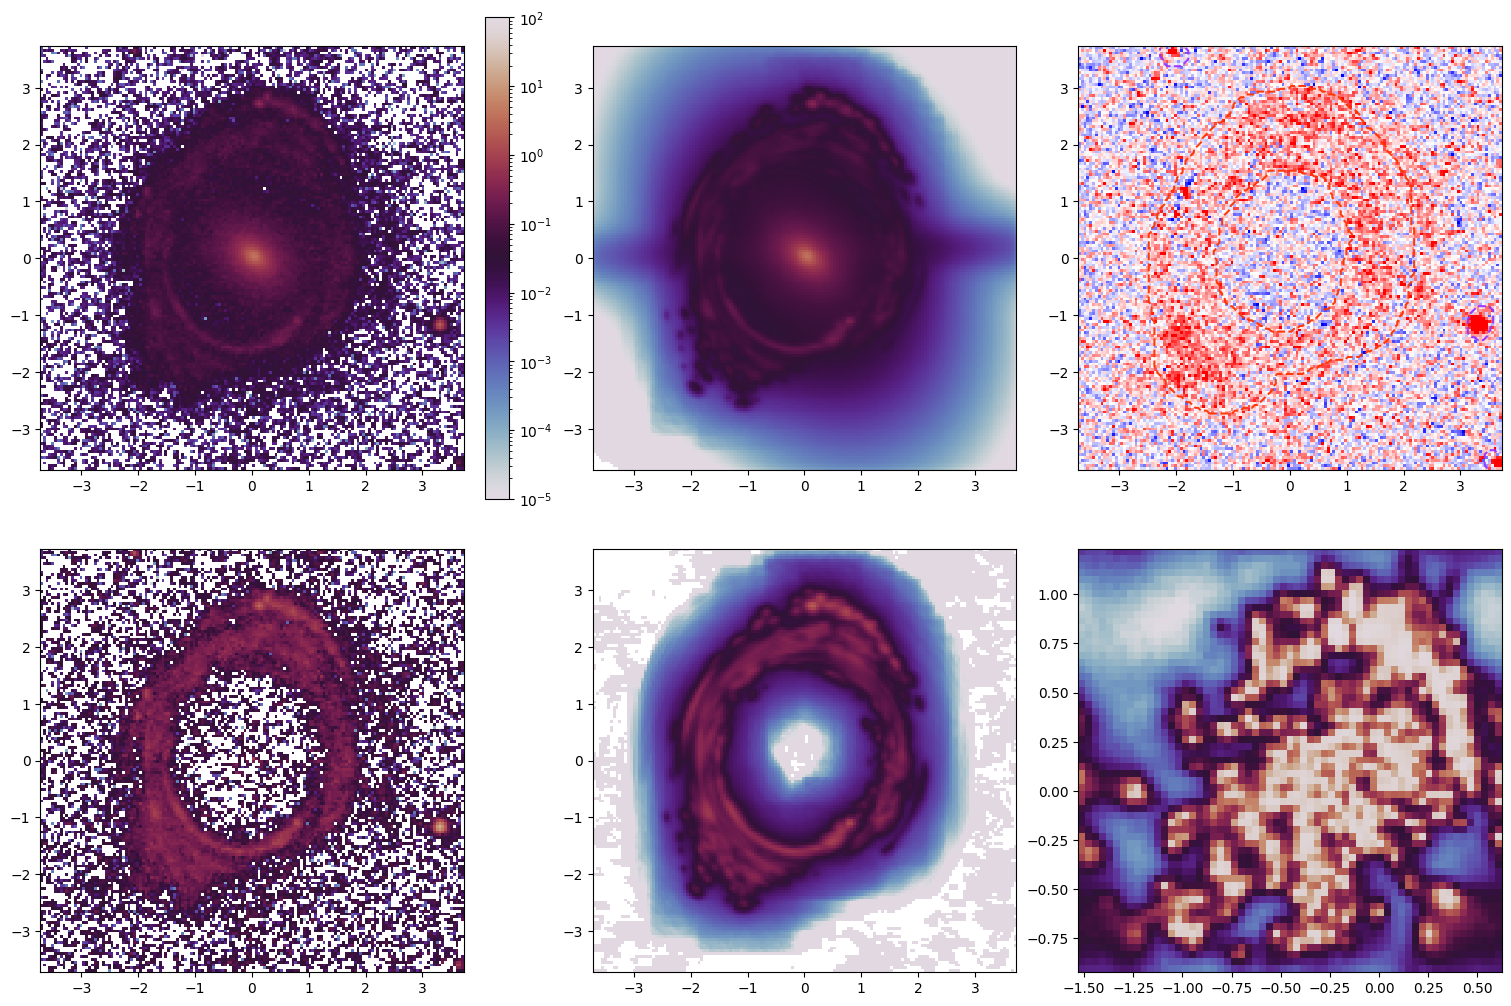

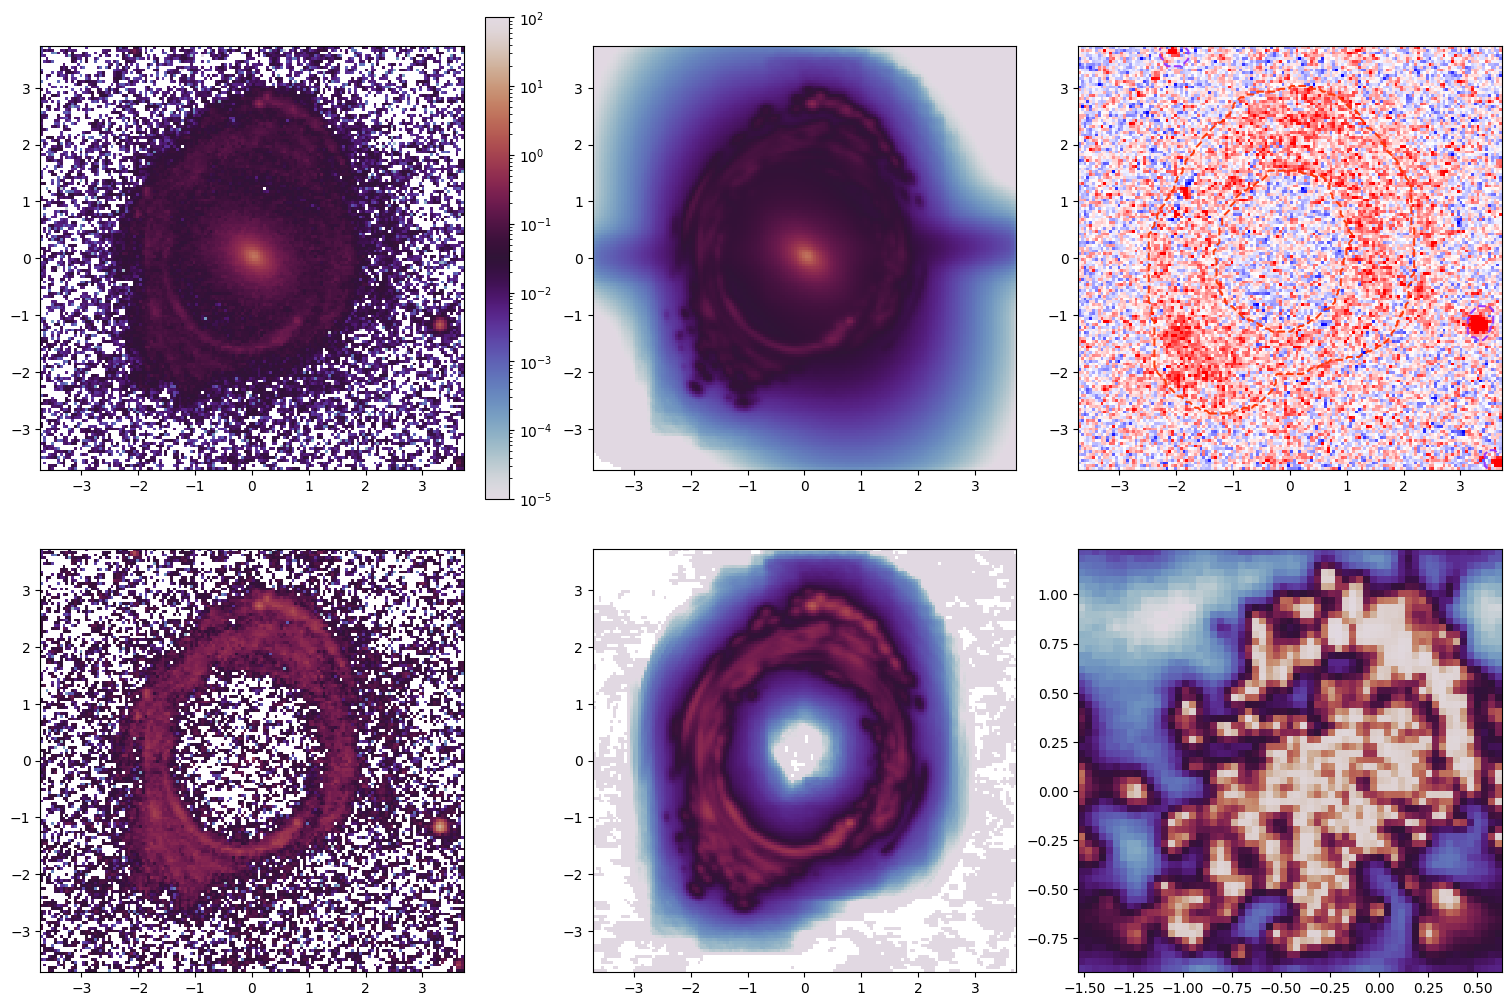

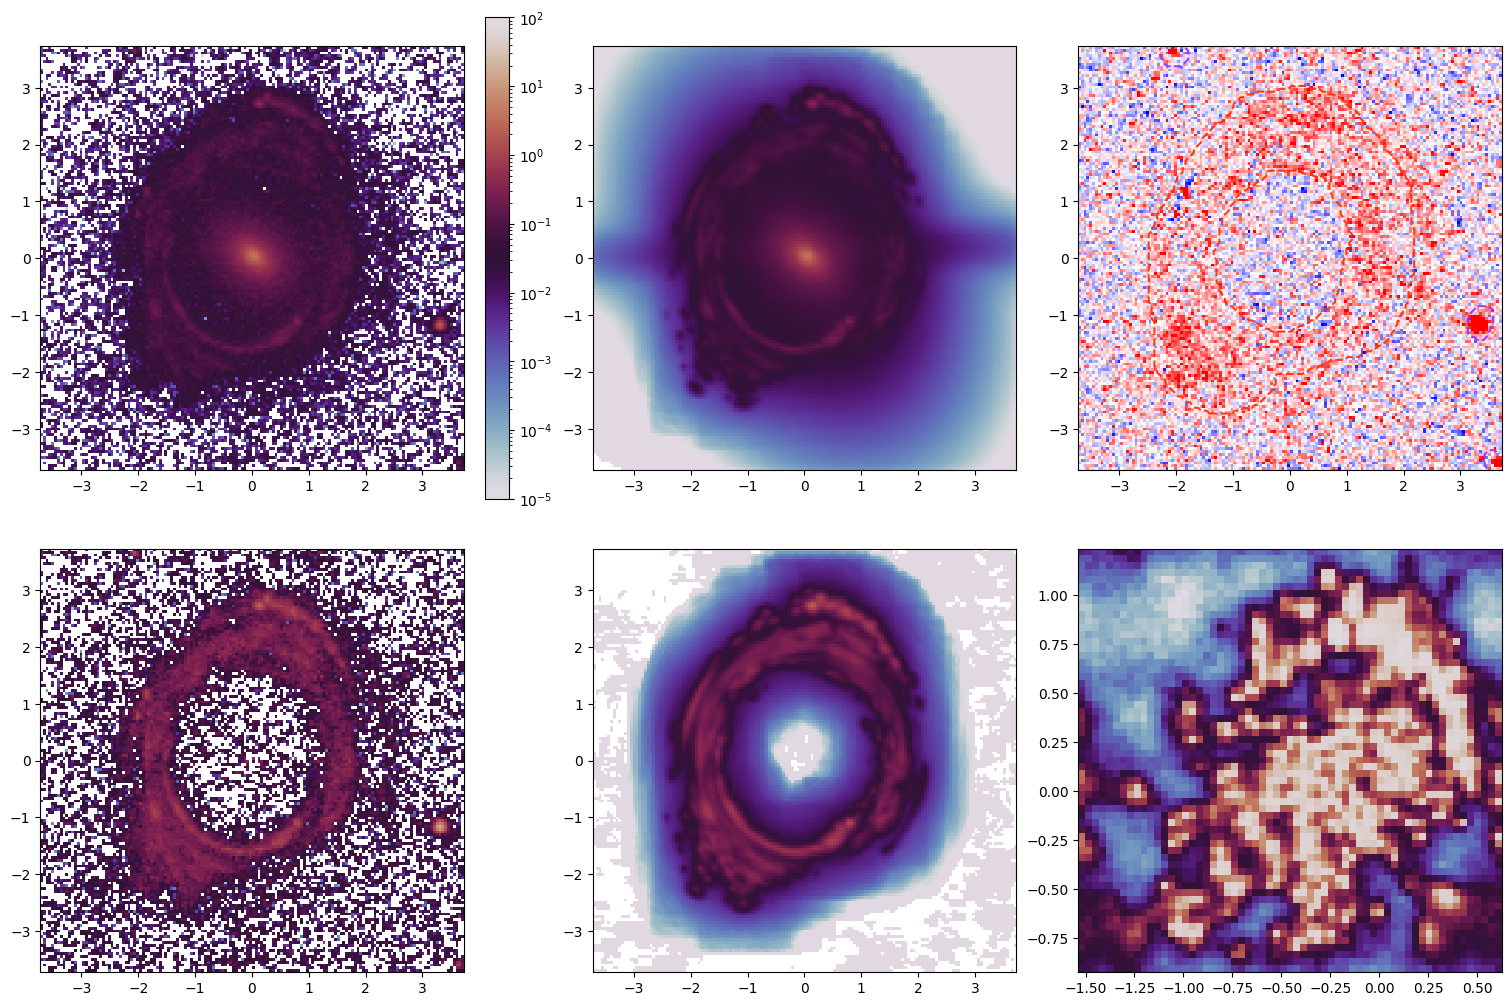

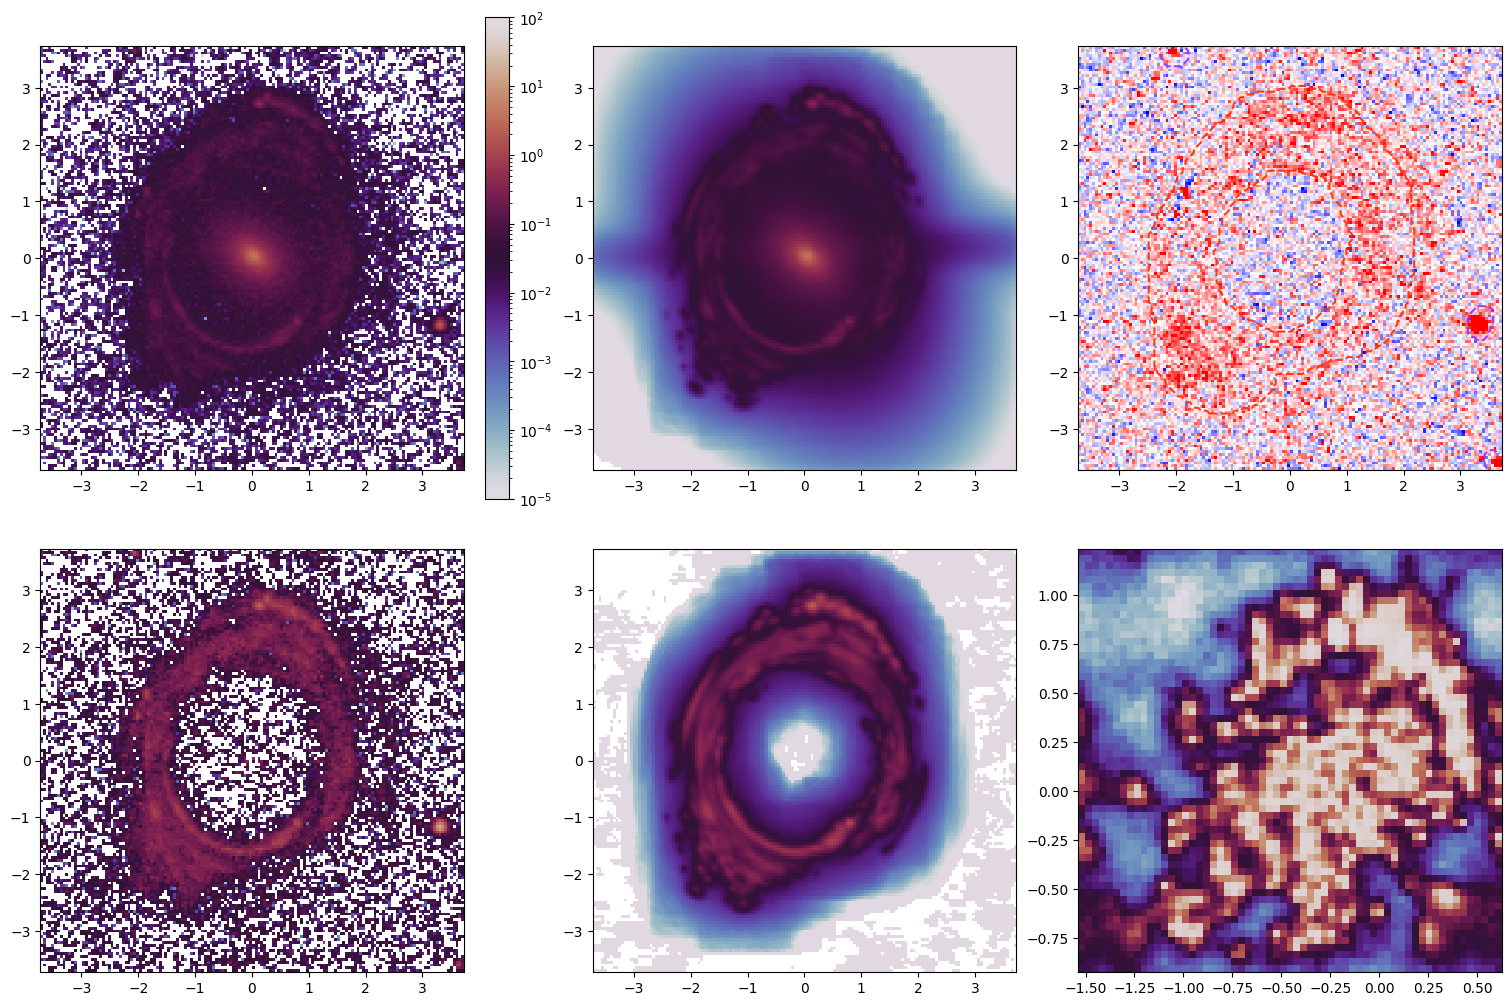

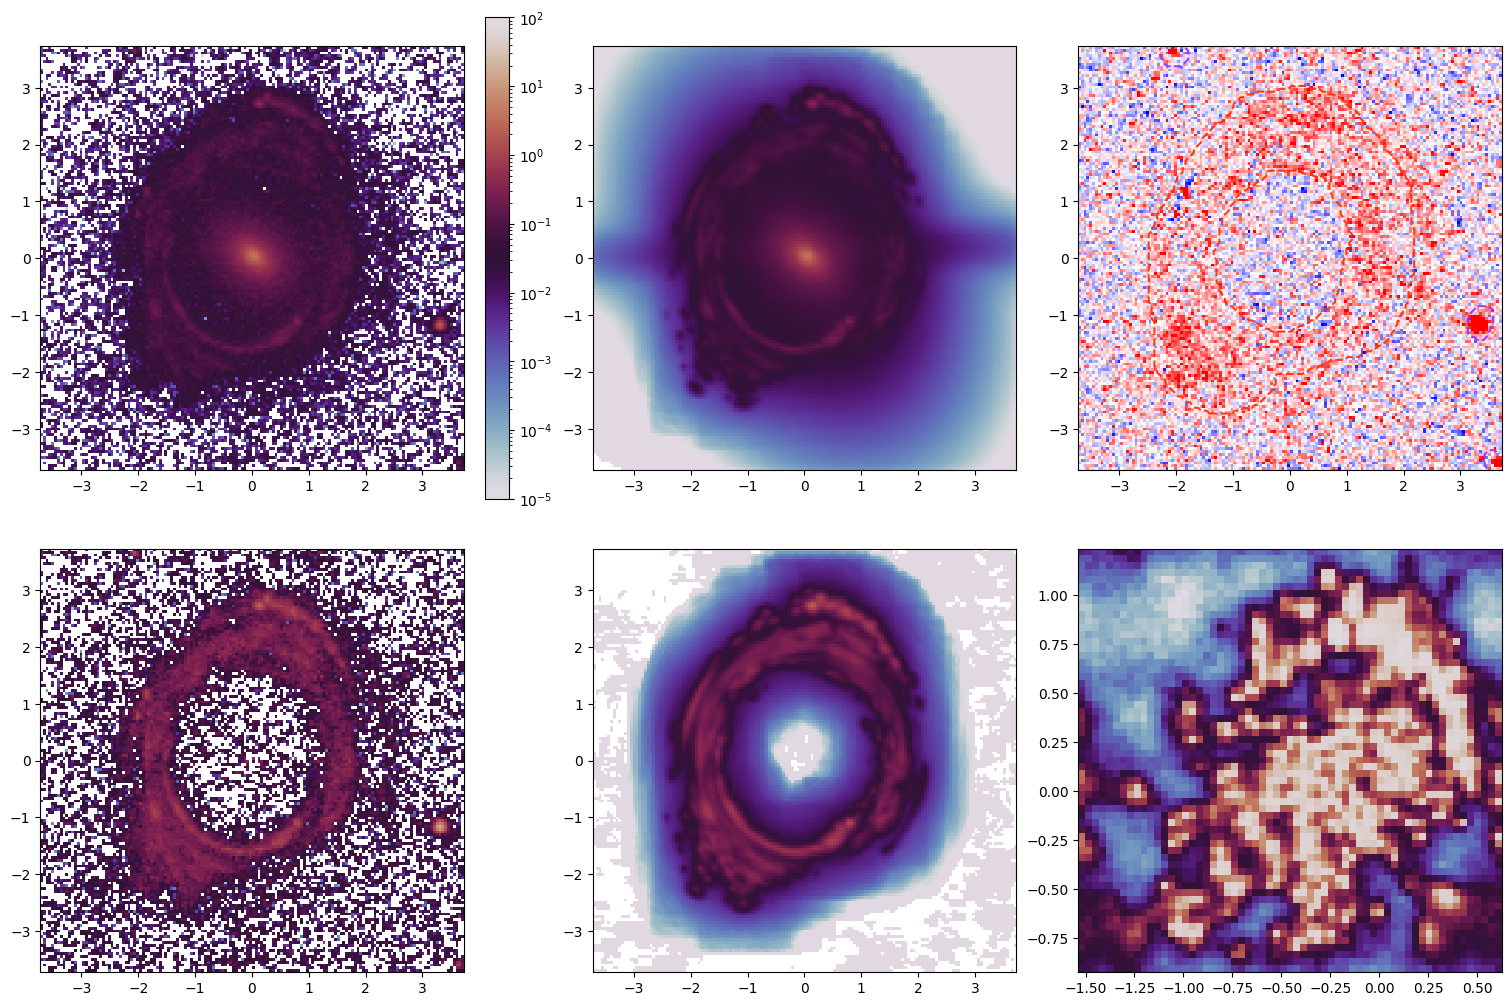

In [24]:
for i in range(5):
    if i == 0:
        result_post = hmc_median_pixel_herc
        background_rms_model = hmc_median_pixel['RMS']
    else:
        result_post = get_value_from_index(hmc_median_pixel_herc_by_chian, i+1)
    plt.figure(figsize = (15,10))
    plt.subplot(2,3,1)
    plt.imshow(data, norm = 'log', cmap = 'twilight', extent = extent, origin = 'lower', vmax = 1e2, vmin = 1e-5)
    plt.colorbar()
    plt.subplot(2,3,2)
    image_model_raw = lens_image_pixel.model(**result_post, source_add = True,)
    image_model = subtract_psf_corner_median(image_model_raw)

    plt.imshow(image_model_raw, norm = 'log', cmap = 'twilight', extent = extent, vmax = 1e2, vmin = 1e-5)
    plt.subplot(2,3,3)
    
    background_rms_model = background_rms_model = hmc_median_pixel['RMS']
    model_var = lens_image_pixel.Noise.C_D_model(image_model_raw, background_rms = background_rms_model)
    model_std = jnp.sqrt(model_var)
    
    plt.imshow((data - image_model)/model_std, cmap = 'bwr', vmax = 3, vmin = -3, extent=extent)
    plt.contour(mask, levels=[0.5], colors='#ff3300', alpha = 0.95, linestyles='dashed', origin='lower', extent=extent)
    plt.contour(mask_out, levels=[0.5], colors='#9933ff', alpha = 0.95, linestyles='dashed', origin='lower', extent=extent)
    plt.subplot(2,3,4)
    lens_light = lens_image_pixel.model(**result_post, source_add = False,)
    plt.imshow(data - lens_light, norm = 'log', cmap = 'twilight', extent = extent, vmax = 1e1, vmin = 1e-5)

    plt.subplot(2,3,5)
    plt.imshow(image_model - lens_light, norm = 'log', cmap = 'twilight', extent = extent, vmax = 1e1, vmin = 1e-5)
    plt.subplot(2,3,6)
    source, source_extent = pixelize_plane_single(
        lens_image_pixel,
        result_post,
        pixel_grid_shape,
    )
    plt.imshow(source, extent = source_extent, norm = 'log', cmap = 'twilight')